In [1]:
import pickle, glob, ast

import numpy as np
import pandas as pd
import geopandas as gpd
import seaborn as sns

import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.colors as colors

from matplotlib import rc
from matplotlib.lines import Line2D
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

from scipy.signal import savgol_filter
from scipy import fftpack
from scipy import stats
from scipy.stats import multivariate_normal, norm
from scipy.ndimage.filters import gaussian_filter1d

import statsmodels.api as sm

from statsmodels.nonparametric.kernel_regression import KernelReg

from ast import literal_eval
from mpl_toolkits.axisartist.axislines import AxesZero
from matplotlib.ticker import StrMethodFormatter, NullFormatter, ScalarFormatter
from matplotlib.transforms import ScaledTranslation
from scipy.stats import norm, multivariate_normal

plt.rcParams['legend.handlelength'] = 1
plt.rcParams['legend.handleheight'] = 1.125
plt.rcParams["font.family"]         = "Avenir"

path_to_results = r'/Users/Guille/Desktop/caiso_power/results/journal_paper_w_sigma/'
path_to_images  = r'/Users/Guille/Desktop/caiso_power/images/'
path_to_mdls    = r'/Users/Guille/Desktop/caiso_power/models/journal_paper_w_sigma/'
path_to_aux     = r'/Users/Guille/Desktop/caiso_power/data/auxiliary/'
path_to_maps    = r'/Users/Guille/Desktop/caiso_power/data/maps/'
path_to_prc     = r'/Users/Guille/Desktop/caiso_power/data/processed/'

# Get California unlities and remove the ones that are not CAISO
_world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
_US    = gpd.read_file(path_to_maps + r"US/tl_2022_us_state.shp")
_CAISO = gpd.read_file(path_to_maps + r"CAISO/Balancing_Authority_Areas_in_CA.shp")
_CAISO = _CAISO.iloc[[1, 7]].to_crs("EPSG:4326")

colors_1_ = ['#7d6674', '#006995', '#f48d64', '#09155a', '#e6cd94', '#0041a5']
colors_2_ = ['#126463', '#2CB7B5', '#CA8250']
colors_3_ = ['#1F390D', '#756A00', '#D8A581', '#92918B']
colors_4_ = ['#126463', '#2CB7B5', '#CA8250', '#756A00', '#92918B']

kernels_ = ['L', 
            'RFB', 
            'P^2', 
            'P^3', 
            'M_{0.5}', 
            'M_{1.5}', 
            'M_{2.5}', 
            'RQ']    

/var/folders/0c/ffx2kgyn7xq4krqrpsv67l3m0000gn/T/ipykernel_3868/912846876.py:21: DeprecationWarning: Please use `gaussian_filter1d` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  from scipy.ndimage.filters import gaussian_filter1d


# Load Independent Energy Forecast Results

In [2]:
def _load_sample_scores(resources_, sl_models_, dl_models_, scores_, path):
    
    _results = {}

    for sl_model in sl_models_:
        _results[sl_model] = {}
        for dl_model in dl_models_:
            _results[sl_model][dl_model] = {}
            for score in scores_:
                _results[sl_model][dl_model][score] = {}
                for resource in resources_:
                    _results[sl_model][dl_model][score][resource] = {}
                        
                    param_   = pd.read_csv(path + f'prob_model_selection_{resource}.csv')
                    filename = '{}-{}-{}-{}.pkl'.format(resource, sl_model, dl_model, score)

                    with open(path + filename, 'rb') as f:
                        _model = pickle.load(f)

                    _results[sl_model][dl_model][score][resource]['targets']     = _model['targets']
                    _results[sl_model][dl_model][score][resource]['predictions'] = _model['mean']
                    _results[sl_model][dl_model][score][resource]['climatology'] = _model['climatology']
                    _results[sl_model][dl_model][score][resource]['persistence'] = _model['persitence']
                    _results[sl_model][dl_model][score][resource]['caiso']       = _model['caiso']
                    
                    idx_   = (param_['sparse_method'] == sl_model) & (param_['dense_method'] == dl_model)
                    idx_   = idx_ & (param_['score'] == score) & (param_['resource'] == resource)
                    thetas = ast.literal_eval(param_.loc[idx_ , 'parameters'].tolist()[0])

                    _results[sl_model][dl_model][score][resource]['parameters']  = thetas

    return _results

path_to_mdls = r'/Users/Guille/Desktop/caiso_power/models/journal_paper_w_sigma/'

resources_  = ['load', 'solar', 'wind']
dl_methods_ = ['BLR', 'RVM', 'GPR', 'MTGPR']
sl_methods_ = ['lasso', 'OMP', 'elastic_net', 'group_lasso']
scores_     = ['RMSE', 'ES', 'LogS', 'VS', 'IS']
scores_     = ['ES']

_is_results = _load_sample_scores(resources_ = resources_, 
                                  sl_models_ = sl_methods_, 
                                  dl_models_ = dl_methods_, 
                                  scores_    = scores_, 
                                  path       = path_to_mdls )

# Load Joint Energy Forecast Results

In [3]:
def _load_sample_ms_scores(zones_, sl_models_, dl_models_, scores_, path):
    
    _results = {}
    param_ = pd.read_csv(path + 'prob_model_selection_multisource.csv')

    for sl_model in sl_models_:
        _results[sl_model] = {}
        for dl_model in dl_models_:
            _results[sl_model][dl_model] = {}
            for score in scores_:
                _results[sl_model][dl_model][score] = {}
                for zone in zones_:
                    _results[sl_model][dl_model][score][zone] = {}


                    filename = '{}-{}-{}-{}.pkl'.format(zone, sl_model, dl_model, score)

                    with open(path + filename, 'rb') as f:
                        _model = pickle.load(f)                    

                    _results[sl_model][dl_model][score][zone]['targets']     = _model['targets']
                    _results[sl_model][dl_model][score][zone]['predictions'] = _model['mean']
                    
                    idx_   = (param_['sparse_method'] == sl_model) & (param_['dense_method'] == dl_model)
                    idx_   = idx_ & (param_['score'] == score) & (param_['resource'] == zone)
                    thetas = ast.literal_eval(param_.loc[idx_ , 'parameters'].tolist()[0])[0]
                    print(sl_model, dl_model, zone, thetas)
                    
                    _results[sl_model][dl_model][score][zone]['parameters'] = thetas

    return _results

path_to_mdls = r'/Users/Guille/Desktop/caiso_power/models/journal_paper_w_sigma_n_lambda-Cal-4/'

zones_      = ['NP15', 'SP15', 'ZP26']
dl_methods_ = ['MTGPR']
sl_methods_ = ['lasso', 'OMP', 'elastic_net', 'group_lasso']
scores_     = ['RMSE', 'ES', 'LogS', 'VS', 'IS']
scores_     = ['ES']

_ms_results = _load_sample_ms_scores(zones_     = zones_, 
                                     sl_models_ = sl_methods_, 
                                     dl_models_ = dl_methods_, 
                                     scores_    = scores_, 
                                     path       = path_to_mdls)

lasso MTGPR NP15 (0.02, 0)
lasso MTGPR SP15 (0.09, 0)
lasso MTGPR ZP26 (0.02, 0)
OMP MTGPR NP15 (80, 0)
OMP MTGPR SP15 (40, 0)
OMP MTGPR ZP26 (20, 0)
elastic_net MTGPR NP15 (0.1, 0.3, 0)
elastic_net MTGPR SP15 (0.1, 0.9, 0)
elastic_net MTGPR ZP26 (0.01, 0.9, 0)
group_lasso MTGPR NP15 (5.0, 0.45, 0)
group_lasso MTGPR SP15 (1.0, 0.45, 0)
group_lasso MTGPR ZP26 (5.0, 0.3, 0)


# Deterministic Model Selection 

In [4]:
def _RMSE(Y_, Y_hat_):
    return np.array([np.sqrt(np.mean((Y_[:, t] - Y_hat_[:, t])**2)) for t in range(Y_hat_.shape[-1])])

def _baselines_MR_RMSE(_results):
    
    dfs_ = []
    
    _results_p = _results[ 'lasso']['BLR']['ES']
    
    Y_1_ = _results_p['load']['targets'][:, 0, :] - _results_p['solar']['targets'][:, 0, :] - _results_p['wind']['targets'][:, 0, :]
    Y_2_ = _results_p['load']['targets'][:, 1, :] - _results_p['solar']['targets'][:, 1, :] - _results_p['wind']['targets'][:, 1, :]
    Y_3_ = _results_p['load']['targets'][:, 2, :] - _results_p['solar']['targets'][:, 2, :] 

    dfs_.append(['NP15', 'average', np.mean(Y_1_, axis = 0).sum()])       
    dfs_.append(['SP15', 'average', np.mean(Y_2_, axis = 0).sum()])                   
    dfs_.append(['ZP26', 'average', np.mean(Y_3_, axis = 0).sum()])   
    dfs_.append(['CAISO', 'average', np.mean(Y_1_ + Y_2_ + Y_3_, axis = 0).sum()])   

    Y_per_1_ = _results_p['load']['persistence'][:, 0, :] - _results_p['solar']['persistence'][:, 0, :] - _results_p['wind']['persistence'][:, 0, :]
    Y_per_2_ = _results_p['load']['persistence'][:, 1, :] - _results_p['solar']['persistence'][:, 1, :] - _results_p['wind']['persistence'][:, 1, :]
    Y_per_3_ = _results_p['load']['persistence'][:, 2, :] - _results_p['solar']['persistence'][:, 2, :] 
    
    dfs_.append(['NP15', 'persistence', _RMSE(Y_1_, Y_per_1_).sum()])       
    dfs_.append(['SP15', 'persistence', _RMSE(Y_2_, Y_per_2_).sum()])                   
    dfs_.append(['ZP26', 'persistence', _RMSE(Y_3_, Y_per_3_).sum()])   
    dfs_.append(['CAISO', 'persistence', _RMSE(Y_1_ + Y_2_ + Y_3_, Y_per_1_ + Y_per_2_ + Y_per_3_).sum()])   

    Y_cli_1_ = _results_p['load']['climatology'][:, 0, :] - _results_p['solar']['climatology'][:, 0, :] - _results_p['wind']['climatology'][:, 0, :]
    Y_cli_2_ = _results_p['load']['climatology'][:, 1, :] - _results_p['solar']['climatology'][:, 1, :] - _results_p['wind']['climatology'][:, 1, :]
    Y_cli_3_ = _results_p['load']['climatology'][:, 2, :] - _results_p['solar']['climatology'][:, 2, :] 

    dfs_.append(['NP15', 'climatology', _RMSE(Y_1_, Y_cli_1_).sum()])       
    dfs_.append(['SP15', 'climatology', _RMSE(Y_2_, Y_cli_2_).sum()])                   
    dfs_.append(['ZP26', 'climatology', _RMSE(Y_3_, Y_cli_3_).sum()])   
    dfs_.append(['CAISO', 'climatology', _RMSE(Y_1_ + Y_2_ + Y_3_, Y_cli_1_ + Y_cli_2_ + Y_cli_3_).sum()])   

    Y_iso_1_ = _results_p['load']['caiso'][:, 0, :] - _results_p['solar']['caiso'][:, 0, :] - _results_p['wind']['caiso'][:, 0, :]
    Y_iso_2_ = _results_p['load']['caiso'][:, 1, :] - _results_p['solar']['caiso'][:, 1, :] - _results_p['wind']['caiso'][:, 1, :]
    Y_iso_3_ = _results_p['load']['caiso'][:, 2, :] - _results_p['solar']['caiso'][:, 2, :] 
         
    dfs_.append(['NP15', 'caiso', _RMSE(Y_1_, Y_iso_1_).sum()])       
    dfs_.append(['SP15', 'caiso', _RMSE(Y_2_, Y_iso_2_).sum()])                   
    dfs_.append(['ZP26', 'caiso', _RMSE(Y_3_, Y_iso_3_).sum()])   
    dfs_.append(['CAISO', 'caiso', _RMSE(Y_1_ + Y_2_ + Y_3_, Y_iso_1_ + Y_iso_2_ + Y_iso_3_).sum()])   

    return pd.DataFrame(dfs_, columns = ['node', 'method', 'RMSE'])

def _independent_MR_RMSE(_results):
    
    dfs_ = []
    for sl_model in _results.keys():
        for dl_model in _results[sl_model].keys():
            for score in _results[sl_model][dl_model].keys():
                _results_p = _results[sl_model][dl_model][score]
                k_1 = ''
                k_2 = ''
                k_3 = ''
                if (dl_model == 'GPR')| (dl_model == 'MTGPR'):
                    k_1 = kernels_[int(_results_p['load']['parameters'][-1])]
                    k_2 = kernels_[int(_results_p['solar']['parameters'][-1])]
                    k_3 = kernels_[int(_results_p['wind']['parameters'][-1])]

                Y_1_ = _results_p['load']['targets'][:, 0, :] - _results_p['solar']['targets'][:, 0, :] - _results_p['wind']['targets'][:, 0, :]
                Y_2_ = _results_p['load']['targets'][:, 1, :] - _results_p['solar']['targets'][:, 1, :] - _results_p['wind']['targets'][:, 1, :]
                Y_3_ = _results_p['load']['targets'][:, 2, :] - _results_p['solar']['targets'][:, 2, :] 

                Y_hat_1_ = _results_p['load']['predictions'][:, 0, :] - _results_p['solar']['predictions'][:, 0, :] - _results_p['wind']['predictions'][:, 0, :]
                Y_hat_2_ = _results_p['load']['predictions'][:, 1, :] - _results_p['solar']['predictions'][:, 1, :] - _results_p['wind']['predictions'][:, 1, :]
                Y_hat_3_ = _results_p['load']['predictions'][:, 2, :] - _results_p['solar']['predictions'][:, 2, :] 
                                
                dfs_.append([sl_model, dl_model, k_1, score, 'NP15', _RMSE(Y_1_, Y_hat_1_).sum()])       
                dfs_.append([sl_model, dl_model, k_2, score, 'SP15', _RMSE(Y_2_, Y_hat_2_).sum()])                   
                dfs_.append([sl_model, dl_model, k_3, score, 'ZP26', _RMSE(Y_3_, Y_hat_3_).sum()])                   
                dfs_.append([sl_model, dl_model, k_1 + k_2 + k_3, score, 'CAISO', _RMSE(Y_1_ + Y_2_ + Y_3_, Y_hat_1_ + Y_hat_2_ + Y_hat_3_).sum()])                   

    return pd.DataFrame(dfs_, columns = ['sparse_method', 'dense_method', 'parameters', 'score', 'node', 'RMSE'])

def _joint_MR_RMSE(_ms_results):
    
    dfs_ = []
    for sl_model in _ms_results.keys():
        for dl_model in _ms_results[sl_model].keys():
            for score in _ms_results[sl_model][dl_model].keys():
                _ms_results_p = _ms_results[sl_model][dl_model][score]
                k_1 = kernels_[int(_ms_results_p['NP15']['parameters'][-1])]
                k_2 = kernels_[int(_ms_results_p['SP15']['parameters'][-1])]
                k_3 = kernels_[int(_ms_results_p['ZP26']['parameters'][-1])]
                                    
                Y_1_ = _ms_results_p['NP15']['targets'][:, 0, :] - _ms_results_p['NP15']['targets'][:, 1, :] - _ms_results_p['NP15']['targets'][:, 2, :]
                Y_2_ = _ms_results_p['SP15']['targets'][:, 0, :] - _ms_results_p['SP15']['targets'][:, 1, :] - _ms_results_p['SP15']['targets'][:, 2, :]
                Y_3_ = _ms_results_p['ZP26']['targets'][:, 0, :] - _ms_results_p['ZP26']['targets'][:, 1, :] 

                Y_hat_1_ = _ms_results_p['NP15']['predictions'][:, 0, :] - _ms_results_p['NP15']['predictions'][:, 1, :] - _ms_results_p['NP15']['predictions'][:, 2, :]
                Y_hat_2_ = _ms_results_p['SP15']['predictions'][:, 0, :] - _ms_results_p['SP15']['predictions'][:, 1, :] - _ms_results_p['SP15']['predictions'][:, 2, :]
                Y_hat_3_ = _ms_results_p['ZP26']['predictions'][:, 0, :] - _ms_results_p['ZP26']['predictions'][:, 1, :] 
                                
                dfs_.append([sl_model, dl_model, k_1, score, 'NP15', _RMSE(Y_1_, Y_hat_1_).sum()])       
                dfs_.append([sl_model, dl_model, k_2, score, 'SP15', _RMSE(Y_2_, Y_hat_2_).sum()])                   
                dfs_.append([sl_model, dl_model, k_3, score, 'ZP26', _RMSE(Y_3_, Y_hat_3_).sum()])                   
                dfs_.append([sl_model, dl_model, k_1, score, 'CAISO', _RMSE(Y_1_ + Y_2_ + Y_3_, Y_hat_1_ + Y_hat_2_ + Y_hat_3_).sum()])                   

    return pd.DataFrame(dfs_, columns = ['sparse_method', 'dense_method', 'parameters', 'score', 'node', 'RMSE'])

In [5]:
def _RMSE(Y_, Y_hat_):
    return np.sqrt(np.mean((Y_ - Y_hat_)**2, axis = 0))

def _baselines_net(_results):
    
    _results_l = _results['elastic_net']['BLR']['ES']['load']
    _results_s = _results['group_lasso']['BLR']['ES']['solar']
    _results_w = _results['elastic_net']['GPR']['ES']['wind']

    Y_1_ = _results_l['targets'][:, 0, :] - _results_s['targets'][:, 0, :] - _results_w['targets'][:, 0, :]
    Y_2_ = _results_l['targets'][:, 1, :] - _results_s['targets'][:, 1, :] - _results_w['targets'][:, 1, :]
    Y_3_ = _results_l['targets'][:, 2, :] - _results_s['targets'][:, 2, :] 
    Y_   = Y_1_ + Y_2_ + Y_3_

    Y_per_1_ = _results_l['persistence'][:, 0, :] - _results_s['persistence'][:, 0, :] - _results_w['persistence'][:, 0, :]
    Y_per_2_ = _results_l['persistence'][:, 1, :] - _results_s['persistence'][:, 1, :] - _results_w['persistence'][:, 1, :]
    Y_per_3_ = _results_l['persistence'][:, 2, :] - _results_s['persistence'][:, 2, :] 
    Y_per_   = Y_per_1_ + Y_per_2_ + Y_per_3_

    Y_cli_1_ = _results_l['climatology'][:, 0, :] - _results_s['climatology'][:, 0, :] - _results_w['climatology'][:, 0, :]
    Y_cli_2_ = _results_l['climatology'][:, 0, :] - _results_s['climatology'][:, 1, :] - _results_w['climatology'][:, 1, :]
    Y_cli_3_ = _results_l['climatology'][:, 2, :] - _results_s['climatology'][:, 2, :] 
    Y_cli_   = Y_cli_1_ + Y_cli_2_ + Y_cli_3_

    Y_iso_1_ = _results_l['caiso'][:, 0, :] - _results_s['caiso'][:, 0, :] - _results_w['caiso'][:, 0, :]
    Y_iso_2_ = _results_l['caiso'][:, 1, :] - _results_s['caiso'][:, 1, :] - _results_w['caiso'][:, 1, :]
    Y_iso_3_ = _results_l['caiso'][:, 2, :] - _results_s['caiso'][:, 2, :] 
    Y_iso_   = Y_iso_1_ + Y_iso_2_ + Y_iso_3_

    return Y_, Y_per_, Y_cli_, Y_iso_

def _independent_net_RMSE(_results):
        
    _results_l = _results['elastic_net']['BLR']['ES']['load']
    _results_s = _results['group_lasso']['BLR']['ES']['solar']
    _results_w = _results['elastic_net']['MTGPR']['ES']['wind']
    #_results_p = _results[sl_model][dl_model][score]

    Y_hat_1_ = _results_l['predictions'][:, 0, :] - _results_s['predictions'][:, 0, :] - _results_w['predictions'][:, 0, :]
    Y_hat_2_ = _results_l['predictions'][:, 1, :] - _results_s['predictions'][:, 1, :] - _results_w['predictions'][:, 1, :]
    Y_hat_3_ = _results_l['predictions'][:, 2, :] - _results_s['predictions'][:, 2, :]
    Y_hat_   = Y_hat_1_ + Y_hat_2_ + Y_hat_3_ 
    
    return Y_hat_

def _joint_net_RMSE(_results):
        
    _results_1 = _results['lasso']['MTGPR']['ES']['NP15']
    _results_2 = _results['lasso']['MTGPR']['ES']['SP15']
    _results_3 = _results['OMP']['MTGPR']['ES']['ZP26']
    #_results_p = _results[sl_model][dl_model][score]

    Y_hat_1_ = _results_1['predictions'][:, 0, :] - _results_1['predictions'][:, 1, :] - _results_1['predictions'][:, 2, :]
    Y_hat_2_ = _results_2['predictions'][:, 0, :] - _results_2['predictions'][:, 1, :] - _results_2['predictions'][:, 2, :]
    Y_hat_3_ = _results_3['predictions'][:, 0, :] - _results_3['predictions'][:, 1, :]
    Y_hat_   = Y_hat_1_ + Y_hat_2_ + Y_hat_3_ 
    
    return Y_hat_

In [6]:
def _RMSE(Y_, Y_hat_):
    return np.array([np.sqrt(np.mean((Y_[:, t] - Y_hat_[:, t])**2)) for t in range(Y_hat_.shape[-1])])


def _baselines_MN_RMSE(_results):
    
    dfs_ = []
    
    sl_model = 'lasso'
    dl_model = 'BLR'
    criteria = 'ES'

    for resource in _results[sl_model][dl_model][criteria].keys():
        Y_ = np.sum(_results[sl_model][dl_model][criteria][resource]['targets'], axis = 1)
        dfs_.append([resource, 'average', np.mean(Y_, axis = 0).sum()])

        Y_hat_ = np.sum(_results[sl_model][dl_model][criteria][resource]['persistence'], axis = 1)
        dfs_.append([resource, 'persistence', _RMSE(Y_, Y_hat_).sum()])

        Y_hat_ = np.sum(_results[sl_model][dl_model][criteria][resource]['caiso'], axis = 1)
        dfs_.append([resource, 'caiso', _RMSE(Y_, Y_hat_).sum()])

        Y_hat_ = np.sum(_results[sl_model][dl_model][criteria][resource]['climatology'], axis = 1)
        dfs_.append([resource, 'climatology', _RMSE(Y_, Y_hat_).sum()])
                    
    return pd.DataFrame(dfs_, columns = ['resource', 'method', 'RMSE'])

def _independent_MN_RMSE(_results):
    
    dfs_ = []
    for sl_model in _results.keys():
        for dl_model in _results[sl_model].keys():
            for score in _results[sl_model][dl_model].keys():
                _results_p = _results[sl_model][dl_model][score]
                
                k_1 = ''
                k_2 = ''
                k_3 = ''
                if (dl_model == 'GPR')| (dl_model == 'MTGPR'):
                    k_1 = kernels_[int(_results_p['load']['parameters'][-1])]
                    k_2 = kernels_[int(_results_p['solar']['parameters'][-1])]
                    k_3 = kernels_[int(_results_p['wind']['parameters'][-1])]
                
                Y_l_     = np.sum(_results_p['load']['targets'], axis = 1)
                Y_l_hat_ = np.sum(_results_p['load']['predictions'], axis = 1)
                dfs_.append([sl_model, dl_model, k_1, score, 'load', _RMSE(Y_l_, Y_l_hat_).sum()])                   
                
                Y_s_      = np.sum(_results_p['solar']['targets'], axis = 1)
                Y_s_hat_ = np.sum(_results_p['solar']['predictions'], axis = 1)
                dfs_.append([sl_model, dl_model, k_2, score, 'solar', _RMSE(Y_s_, Y_s_hat_).sum()])  
                
                Y_w_     = np.sum(_results_p['wind']['targets'], axis = 1)
                Y_w_hat_ = np.sum(_results_p['wind']['predictions'], axis = 1)
                dfs_.append([sl_model, dl_model, k_3, score, 'wind', _RMSE(Y_w_, Y_w_hat_).sum()])  
             
                dfs_.append([sl_model, dl_model, k_1 + k_2 + k_3, score, 'net', _RMSE(Y_l_ - Y_s_ - Y_w_, Y_l_hat_ - Y_s_hat_ - Y_w_hat_).sum()])  

    return pd.DataFrame(dfs_, columns = ['sparse_method', 'dense_method', 'parameters', 'score', 'resource', 'RMSE'])

def _joint_MN_RMSE(_ms_results):
    
    dfs_ = []
    for sl_model in _ms_results.keys():
        for dl_model in _ms_results[sl_model].keys():
            for score in _ms_results[sl_model][dl_model].keys():
                _ms_results_p = _ms_results[sl_model][dl_model][score]
                
                k_1 = kernels_[int(_ms_results_p['NP15']['parameters'][-1])]
                k_2 = kernels_[int(_ms_results_p['SP15']['parameters'][-1])]
                k_3 = kernels_[int(_ms_results_p['ZP26']['parameters'][-1])]
                
                Y_l_     = _ms_results_p['NP15']['targets'][:, 0, :] + _ms_results_p['SP15']['targets'][:, 0, :] + _ms_results_p['ZP26']['targets'][:, 0, :]
                Y_l_hat_ = _ms_results_p['NP15']['predictions'][:, 0, :] + _ms_results_p['SP15']['predictions'][:, 0, :] + _ms_results_p['ZP26']['predictions'][:, 0, :]
                dfs_.append([sl_model, dl_model, k_1, score, 'load', _RMSE(Y_l_, Y_l_hat_).sum()])                   

                Y_s_     = _ms_results_p['NP15']['targets'][:, 1, :] + _ms_results_p['SP15']['targets'][:, 1, :] + _ms_results_p['ZP26']['targets'][:, 1, :]
                Y_s_hat_ = _ms_results_p['NP15']['predictions'][:, 1, :] + _ms_results_p['SP15']['predictions'][:, 1, :] + _ms_results_p['ZP26']['predictions'][:, 1, :]
                dfs_.append([sl_model, dl_model, k_2, score, 'solar', _RMSE(Y_s_, Y_s_hat_).sum()])  
                
                Y_w_     = _ms_results_p['NP15']['targets'][:, 2, :] + _ms_results_p['SP15']['targets'][:, 2, :]
                Y_w_hat_ = _ms_results_p['NP15']['predictions'][:, 2, :] + _ms_results_p['SP15']['predictions'][:, 2, :]
                dfs_.append([sl_model, dl_model, k_3, score, 'wind', _RMSE(Y_w_, Y_w_hat_).sum()])  
                
                dfs_.append([sl_model, dl_model, '', score, 'net', _RMSE(Y_l_ - Y_s_ - Y_w_, Y_l_hat_ - Y_s_hat_ - Y_w_hat_).sum()])  
                
    return pd.DataFrame(dfs_, columns = ['sparse_method', 'dense_method', 'parameters', 'score', 'resource', 'RMSE'])

## Model Selection - Forecasting Skill

In [10]:
def _plot_NL_FS(ax, Scores_, ref_, zones_p_, colors_, 
                legend_labels_ = [], 
                legend_title   = '', 
                dense_method   = '',
                score          = 'RMSE',
                xlabel         = '',
                ylabel         = '', 
                title          = '', 
                markers        = True,
                y_max          = 10,
                y_min          = 0,
                legend         = False):

    sparse_methods_ = Scores_['sparse_method'].unique()
    zones_          = Scores_['node'].unique()
    markers_        = ['o', 'p', '^', 'd']
    dense_methods_  = ['BLR', 'RVM', 'GPR', 'MTGPR']
    
    x_ = np.linspace(0, .333*len(sparse_methods_), len(sparse_methods_))

    width  = 0.4
    offset = 2.
    
    ax.set_title(title, fontsize = 18, loc = "center")

    ticks_  = []
    values_ = []
    j       = 0

    for zone in zones_:
        i = 0
        for sparse_method in sparse_methods_:
            
            idx_1_ = (Scores_['sparse_method'] == sparse_method) & (Scores_['node'] == zone) & (Scores_['dense_method'] == dense_method)  & (Scores_['score'] == score)
            idx_2_ = (ref_['method'] == 'caiso') & (ref_['node'] == zone)
            idx_1_ = (Scores_['sparse_method'] == sparse_method) & (Scores_['node'] == zone) 
            RMSE = Scores_.loc[idx_1_].groupby(['dense_method', 'sparse_method', 'node']).min().reset_index()['RMSE'].min()
            sel_dense_method = Scores_.loc[Scores_['RMSE'] == RMSE, 'dense_method'].to_list()[0]
            
            params = Scores_.loc[Scores_['RMSE'] == RMSE, 'parameters'].to_list()[0]
            kernel = ''
            if params != '':
                params = r'$\mathcal{K}_{' + f'{params}' + '}$'
                kernel = f'{params}'
                    
            y = 100*(1. -  RMSE/ref_.loc[idx_2_, 'RMSE'].min())
            p = ax.bar(x_[i], y, width, color  = colors_[i], 
                                         zorder = 9, 
                                         align  = 'center')
                               
            if markers:
                ax.bar_label(p, labels = [f'{x:,.1f}' for x in p.datavalues], size = 12, padding = 5)
                ax.bar_label(p, labels = [kernel for x in p.datavalues], size = 14, rotation = 90, padding = 20)
 
                ax.scatter(x_[i], y, marker    = markers_[dense_methods_.index(sel_dense_method)], 
                                     s         = 75, 
                                     edgecolor = 'k', 
                                     lw        = 1., 
                                     color     = 'w', 
                                     zorder    = 10)
            else:
                ax.bar_label(p, labels = [f'{x:,.1f}' for x in p.datavalues], size = 12)
                ax.bar_label(p, labels = [kernel for x in p.datavalues], size = 14, rotation = 90, padding = 15)

            i += 1
        
        ticks_.append(x_.mean())

        x_ += offset
        j  += 1
    
    ax.set_xticks(ticks_[:len(zones_)], zones_p_, fontsize = 10)
    
    ax.set_ylim(y_min, y_max)

    legend_ = []
    for i in range(len(legend_labels_)):
        legend_.append(Line2D([0], [0], marker          = 's', 
                                        markerfacecolor = colors_[i], 
                                        markeredgecolor = colors_[i], 
                                        markersize      = 6,
                                        label           = legend_labels_[i],
                                        color           = "None"))
    # if legend:
    #     ax.legend(handles        = legend_, 
    #               title          = legend_title, 
    #               prop           = {'size': 14}, 
    #               title_fontsize = 16,
    #               ncol           = 1, 
    #               columnspacing  = 0., 
    #               handletextpad  = 0.,  
    #               bbox_to_anchor = [1., .75, .25, .25],
    #               frameon        = False)

    
    s = 125
    legend_ = []

    legend_.append(Line2D([0], [0], marker          = 'o', 
                                    markerfacecolor = 'w', 
                                    color           = "None",
                                    markeredgecolor = 'k', 
                                    markersize      = s/15,
                                    markeredgewidth = .5,
                                    label           = 'BLR'))

    legend_.append(Line2D([0], [0], marker          = 'p', 
                                    markerfacecolor = 'w', 
                                    color           = "None",
                                    markeredgecolor = "k", 
                                    markersize      = s/12,
                                    markeredgewidth = .5,
                                    label           = 'RVM'))

    legend_.append(Line2D([0], [0], marker          = '^', 
                                    markerfacecolor = 'w', 
                                    color           = "None",
                                    markeredgecolor = "k", 
                                    markersize      = s/13,
                                    markeredgewidth = .5,
                                    label           = 'GPR'))

    legend_.append(Line2D([0], [0], marker          = 'd', 
                                    color           = "None",
                                    markerfacecolor = 'w', 
                                    markeredgecolor = "k", 
                                    markersize      = s/16,
                                    markeredgewidth = .5,
                                    label           = 'NLGPR'))

    if legend:
        _leg_2 = ax.legend(handles         = legend_, 
                           prop           = {'size': 14}, 
                           title          = "Bayesian Learning", 
                           title_fontsize = 16,
                           ncol           = 2, 
                           columnspacing  = 0.5, 
                           handletextpad  = 0.5,  
                           labelspacing   = 0.5,
                           #bbox_to_anchor = [1.05, .15],
                           loc            = "upper left",
                           frameon        = False)
        
        ax.add_artist(_leg_2)
        
    ax.grid(axis = 'y')

    ax.xaxis.set_tick_params(labelsize = 14, left = False)
    ax.yaxis.set_tick_params(labelsize = 14, left = False)
    
    ax.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))

    ax.spines[['right', 'top', 'left', 'bottom']].set_visible(False)
    
    ax.set_ylabel(ylabel, fontsize = 16)
    ax.set_xlabel(xlabel, fontsize = 16)
    
    ax.axhline(0, linewidth = .5, 
                  linestyle = '-', 
                  color     = 'k', 
                  clip_on   = False, 
                  zorder    = 10)
    
    
def _plot_NL_baseline(ax, Scores_, zones_p_, colors_, 
                      legend_labels_ = [], 
                      legend_title   = '', 
                      score          = 'value',
                      ref_           = [],
                      xlabel         = '',
                      ylabel         = '', 
                      title          = '', 
                      y_max          = 25,
                      y_min          = 0,
                      legend         = False):
    
    methods_ = ['persistence', 'climatology', 'caiso']
    zones_   = Scores_['node'].unique()    
    
    x_     = np.linspace(0, .333*len(methods_), len(methods_))
    width  = 0.4
    offset = 2.
    
    ax.set_title(title, fontsize = 18, loc = "center")

    ticks_ = []
    j      = 0
    for zone in zones_:
        i = 0
        for method in methods_:

            idx_1_ = (Scores_['method'] == method) & (Scores_['node'] == zone) 
            idx_2_ = (Scores_['method'] == 'average') & (Scores_['node'] == zone) 
            
            y = 100.*Scores_.loc[idx_1_, score].min()/Scores_.loc[idx_2_, score].min()
            p = ax.bar(x_[i], y, width, color  = colors_[i], 
                                         zorder = 9, 
                                         align  = 'center')
            
            ax.bar_label(p, labels = [f'{x:,.1f}' for x in p.datavalues], 
                            size   = 12)
           
            i += 1
        
        ticks_.append(x_.mean())
        x_ += offset
        j  += 1
 

    ax.set_xticks(ticks_[:len(zones_)], zones_p_, fontsize = 10)
    
    legend_ = []
    for i in range(len(legend_labels_)):
        legend_.append(Line2D([0], [0], marker          = 's', 
                                        markerfacecolor = colors_[i], 
                                        markeredgecolor = colors_[i], 
                                        markersize      = 6,
                                        label           = legend_labels_[i],
                                        color           = "None"))
    if legend:
        ax.legend(handles        = legend_, 
                   title          = legend_title, 
                   prop           = {'size': 14}, 
                   title_fontsize = 16,
                   ncol           = 1, 
                   columnspacing  = 0.5, 
                   handletextpad  = 0.5,  
                   labelspacing   = 0.5,
                   #bbox_to_anchor = [1.05, .15],
                   loc            = "upper left",
                   frameon        = False)
        
    ax.grid(axis = 'y')

    ax.xaxis.set_tick_params(labelsize = 14, left = False)
    ax.yaxis.set_tick_params(labelsize = 14, left = False)
    
    ax.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))

    ax.spines[['right', 'top', 'left', 'bottom']].set_visible(False)
    
    ax.set_ylabel(ylabel, fontsize = 16)
    ax.set_xlabel(xlabel, fontsize = 16)
    
    ax.axhline(0, linewidth = .5, 
                  linestyle = '-', 
                  color     = 'k', 
                  clip_on   = False, 
                  zorder    = 10)

    ax.set_ylim(y_min, y_max)
    
def _plot_SL_FS(ax, Scores_, ref_, zones_p_, colors_, 
                     legend_labels_  = [], 
                     legend_title    = '', 
                     dense_method    = '',
                     score           = 'RMSE',
                     xlabel          = '',
                     ylabel          = '', 
                     title           = '', 
                     letter          = '', 
                     y_max           = 25,
                     y_min           = 0,
                     markers         = True,
                     legend          = False):      

    resources_      = Scores_['resource'].unique()
    sparse_methods_ = Scores_['sparse_method'].unique()
    markers_        = ['o', 'p', '^', 'd']
    dense_methods_  = ['BLR', 'RVM', 'GPR', 'MTGPR']

    x_ = np.linspace(0, .333*len(sparse_methods_), len(sparse_methods_))

    width  = 0.4
    offset = 2.
    
    ax.set_title(title, fontsize = 18, loc = "center")

    ticks_  = []
    values_ = []
    j       = 0
    
    for resource in resources_:
        i = 0
        for sparse_method in sparse_methods_:
            
            idx_2_ = (ref_['method'] == 'caiso') & (ref_['resource'] == resource)
            idx_1_ = (Scores_['sparse_method'] == sparse_method) & (Scores_['resource'] == resource) 
            #print(Scores_.loc[idx_1_])
            RMSE = Scores_.loc[idx_1_].groupby(['resource', 'sparse_method']).min().reset_index()['RMSE'].min()
            sel_dense_method = Scores_.loc[Scores_['RMSE'] == RMSE, 'dense_method'].to_list()[0]

            y = 100*(1. -  RMSE/ref_.loc[idx_2_, 'RMSE'].min())
            
            params = Scores_.loc[Scores_['RMSE'] == RMSE, 'parameters'].to_list()[0]
            kernel = ''
            if params != '':
                params = r'$\mathcal{K}_{' + f'{params}' + '}$'
                kernel = f'{params}'

            p = ax.bar(x_[i], y, width, color  = colors_[i], 
                                         zorder = 9, 
                                         align  = 'center')
                           
            if markers:
                ax.bar_label(p, labels = [f'{x:,.1f}' for x in p.datavalues], size = 12, padding = 5)
                ax.bar_label(p, labels = [kernel for x in p.datavalues], size = 14, padding = 20, rotation = 90)
                ax.scatter(x_[i], y, marker    = markers_[dense_methods_.index(sel_dense_method)], 
                                     s         = 75, 
                                     edgecolor = 'k', 
                                     lw        = 1., 
                                     color     = 'w', 
                                     zorder    = 10)
            else:
                ax.bar_label(p, labels = [f'{x:,.1f}' for x in p.datavalues], size = 12)
                ax.bar_label(p, labels = [kernel for x in p.datavalues], size = 14, rotation = 90, padding = 15)

            i += 1
        
        ticks_.append(x_.mean())

        x_ += offset
        j  += 1
 
    ax.set_xticks(ticks_[:len(zones_p_)], zones_p_, fontsize = 10)
    
    ax.set_ylim(y_min, y_max)

    legend_ = []
    for i in range(len(legend_labels_)):
        legend_.append(Line2D([0], [0], marker          = 's', 
                                        markerfacecolor = colors_[i], 
                                        markeredgecolor = colors_[i], 
                                        markersize      = 6,
                                        label           = legend_labels_[i],
                                        color           = "None"))
    if legend:
        _leg_1 = ax.legend(handles        = legend_, 
                           title          = legend_title, 
                           prop           = {'size': 14}, 
                           title_fontsize = 16,
                           ncol           = 2, 
                           columnspacing  = 0.5, 
                           handletextpad  = 0.5,  
                           labelspacing   = 0.5,
                           #bbox_to_anchor = [1., .72, .25, .25],
                           loc            = "upper right",
                           frameon        = False)
        
        ax.add_artist(_leg_1)


    
    s = 125
    legend_ = []

    legend_.append(Line2D([0], [0], marker          = 'o', 
                                    markerfacecolor = 'w', 
                                    color           = "None",
                                    markeredgecolor = 'k', 
                                    markersize      = s/15,
                                    markeredgewidth = .5,
                                    label           = 'BLR'))

    legend_.append(Line2D([0], [0], marker          = 'p', 
                                    markerfacecolor = 'w', 
                                    color           = "None",
                                    markeredgecolor = "k", 
                                    markersize      = s/12,
                                    markeredgewidth = .5,
                                    label           = 'RVM'))

    legend_.append(Line2D([0], [0], marker          = '^', 
                                    markerfacecolor = 'w', 
                                    color           = "None",
                                    markeredgecolor = "k", 
                                    markersize      = s/13,
                                    markeredgewidth = .5,
                                    label           = 'GPR'))

    legend_.append(Line2D([0], [0], marker          = 'd', 
                                    color           = "None",
                                    markerfacecolor = 'w', 
                                    markeredgecolor = "k", 
                                    markersize      = s/16,
                                    markeredgewidth = .5,
                                    label           = 'SLGPR'))

    if legend:
        _leg_2 = ax.legend(handles         = legend_, 
                           prop           = {'size': 14}, 
                           title          = "Bayesian Learning", 
                           title_fontsize = 16,
                           ncol           = 2, 
                           columnspacing  = 0.5, 
                           handletextpad  = 0.5,  
                           labelspacing   = 0.5,
                           #bbox_to_anchor = [1.05, .15],
                           loc            = "upper left",
                           frameon        = False)
        
        ax.add_artist(_leg_2)
        
    ax.grid(axis = 'y')

    ax.xaxis.set_tick_params(labelsize = 14, left = False)
    ax.yaxis.set_tick_params(labelsize = 14, left = False)
    
    ax.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))

    ax.spines[['right', 'top', 'left', 'bottom']].set_visible(False)
    
    ax.set_ylabel(ylabel, fontsize = 16)
    ax.set_xlabel(xlabel, fontsize = 16)
    
    ax.axhline(0, linewidth = .5, 
                  linestyle = '-', 
                  color     = 'k', 
                  clip_on   = False, 
                  zorder    = 10)


def _plot_SL_baseline(ax, Scores_, zones_p_, colors_, 
                      legend_labels_ = [], 
                      legend_title   = '', 
                      score          = '',
                      xlabel         = '',
                      ylabel         = '', 
                      title          = '', 
                      y_max          = 25,
                      y_min          = 0,
                      legend         = False):

    methods_   = ['persistence', 'climatology', 'caiso']
    resources_ = Scores_['resource'].unique()

    x_     = np.linspace(0, .333*len(methods_), len(methods_))
    width  = 0.4
    offset = 2.
    
    ax.set_title(title, fontsize = 18, loc = "center")

    ticks_ = []
    j      = 0
    
    for resource in resources_:
        i = 0
        for method in methods_:
            idx_1_ = (Scores_['method'] == method) & (Scores_['resource'] == resource) 
            idx_2_ = (Scores_['method'] == 'average') & (Scores_['resource'] == resource) 

            y = 100.*Scores_.loc[idx_1_, score].min()/Scores_.loc[idx_2_, score].min()
            
            p = ax.bar(x_[i], y, width, color  = colors_[i], 
                                        zorder = 9, 
                                        align  = 'center')
            
            ax.bar_label(p, labels = [f'{x:,.1f}' for x in p.datavalues], size = 12)
           
            i += 1
        
        ticks_.append(x_.mean())
        x_ += offset
        j += 1

    ax.set_xticks(ticks_[:len(zones_p_)], zones_p_, fontsize = 10)
    
    legend_ = []
    for i in range(len(legend_labels_)):
        legend_.append(Line2D([0], [0], marker          = 's', 
                                        markerfacecolor = colors_[i], 
                                        markeredgecolor = colors_[i], 
                                        markersize      = 6,
                                        label           = legend_labels_[i],
                                        color           = "None"))
    if legend:
        ax.legend(handles         = legend_, 
                   title          = legend_title, 
                   prop           = {'size': 14}, 
                   title_fontsize = 16,
                   ncol           = 1, 
                   columnspacing  = 0.5, 
                   handletextpad  = 0.5,  
                   labelspacing   = 0.5,
                   frameon        = False)

    
    ax.grid(axis = 'y')

    ax.xaxis.set_tick_params(labelsize = 14, left = False)
    ax.yaxis.set_tick_params(labelsize = 14, left = False)
    
    ax.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))

    ax.spines[['right', 'top', 'left', 'bottom']].set_visible(False)
    
    ax.set_ylabel(ylabel, fontsize = 16)
    ax.set_xlabel(xlabel, fontsize = 16)
    
    ax.axhline(0, linewidth = .5, 
                  linestyle = '-', 
                  color     = 'k', 
                  clip_on   = False, 
                  zorder    = 10)

    ax.set_ylim(y_min, y_max)
    

def _plot_hourly_percentail(ax, models_, E_, colors_, N_percentil):
    width  = 0.175
    offset = 1.3

    ticks_ = []
    x_     = np.linspace(0, width*len(models_), len(models_))
    percentiles_ = np.arange(0, N_percentil, 1, dtype = int)
    for i_percentile in percentiles_:

        i = 0
        for i_model in range(len(models_)):

            df_      = pd.DataFrame()
            df_['y'] = np.array(E_[i_model][i_percentile])/1000.
            df_['x'] = x_[i]

            _box = ax.boxplot(df_['y'], positions    = [x_[i]], 
                                        showmeans    = True, 
                                        showfliers   = False, 
                                        patch_artist = True, 
                                        zorder       = 10)

            # change outline color
            _box['boxes'][0].set(color = colors_[i_model], linewidth = .5, edgecolor = 'k', facecolor = colors_[i_model], alpha = 1.)
            _box['medians'][0].set(color = 'w', zorder = 10)
            #_box['medians'][0].set(marker = "^", markersize = 5., markeredgewidth = .75, markeredgecolor = 'k', markerfacecolor = 'g')

            _box['means'][0].set(marker = "o", markersize = 4., markeredgewidth = .5, markeredgecolor = 'k', markerfacecolor = 'white')
            #_box['fliers'][0].set(marker = "o", markersize = 1.25, markeredgewidth = .5,  markeredgecolor = 'k', markerfacecolor = 'None', alpha = .5)
            _box['whiskers'][0].set(linewidth = .5)
            _box['whiskers'][1].set(linewidth = .5)
            _box['caps'][0].set(linewidth = .5)
            _box['caps'][1].set(linewidth = .5)

            i +=1 

        ticks_.append(x_.mean())
        x_ += offset

    ax.xaxis.set_tick_params(labelsize = 14)
    ax.yaxis.set_tick_params(labelsize = 14)
    ax.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))
    ax.spines[['right', 'top', 'left', 'bottom']].set_visible(False)

    ax.set_ylabel('Absolute Residuals', fontsize = 14)
    ax.set_xlabel('Net Load Percentiles', fontsize = 14)

    #ax.set_ylim(-1.,)

#     legend_ = []
#     for i_model in range(len(models_)):
#         legend_.append(Line2D([0], [0], marker          = 's', 
#                                         markerfacecolor = colors_[i_model], 
#                                         markeredgecolor = colors_[i_model], 
#                                         markersize      = 6,
#                                         label           = models_[i_model],
#                                         color           = "None"))
        
#     _leg_1 = ax.legend(handles        = legend_, 
#                        title          = 'Forecast', 
#                        prop           = {'size': 14}, 
#                        title_fontsize = 16,
#                        ncol           = 1, 
#                        columnspacing  = 0., 
#                        handletextpad  = 0.,  
#                        #bbox_to_anchor = [.975, .8],
#                        frameon        = False)
#     ax.add_artist(_leg_1)


    legend_ = []

    legend_.append(Line2D([0], [0], marker          = 'o', 
                                    markerfacecolor = None, 
                                    markeredgecolor = 'k', 
                                    markersize      = 4,
                                    label           = 'mean',
                                    color           = "None"))

    legend_.append(Line2D([0], [0], marker          = '_', 
                                    markerfacecolor = "k", 
                                    markeredgecolor = "k", 
                                    markersize      = 6,
                                    label           = 'median',
                                    color           = "None"))

    _leg_2 = ax.legend(handles        = legend_, 
                        prop           = {'size': 14}, 
                        title_fontsize = 14,
                        ncol           = 1, 
                       columnspacing  = 0.5, 
                       handletextpad  = 0.5,  
                       labelspacing   = 0.5,
                        #bbox_to_anchor = [0.35, .65],
                        #loc            = 'upper left',
                        frameon        = False)

    ax.add_artist(_leg_2)

    ax.grid(axis      = 'y', 
            alpha     = .5, 
            linestyle = '-')

    sns.despine(trim   = True, 
                offset = 5, 
                ax     = ax)
    
    ax.set_xticks(ticks_, ['1st', '2nd', '3rd'] + [f'{i_percentile + 1}th' for i_percentile in percentiles_[3:].astype(int)], 
                  rotation = 45)
    

def _plot_hourly_error(ax, models_, E_, colors_):
    width  = 0.175
    offset = 1.25

    ticks_ = []
    x_     = np.linspace(0, width*len(models_), len(models_))
    hours_ = np.arange(0, 24, 1, dtype = int)
    for i_hour in hours_:

        i = 0
        for i_model in range(len(models_)):

            df_      = pd.DataFrame()
            df_['y'] = E_[i_model][:, i_hour]/1000.
            df_['x'] = x_[i]

            _box = ax.boxplot(df_['y'], positions    = [x_[i]], 
                                        showmeans    = True, 
                                        showfliers   = False, 
                                        patch_artist = True, 
                                        zorder       = 10)

            # change outline color
            _box['boxes'][0].set(color = colors_[i_model], linewidth = .5, edgecolor = 'k', facecolor = colors_[i_model], alpha = 1.)
            _box['medians'][0].set(color = 'w', zorder = 10)
            #_box['medians'][0].set(marker = "^", markersize = 5., markeredgewidth = .75, markeredgecolor = 'k', markerfacecolor = 'g')

            _box['means'][0].set(marker = "o", markersize = 4., markeredgewidth = .5, markeredgecolor = 'k', markerfacecolor = 'white')
            #_box['fliers'][0].set(marker = "o", markersize = 1.25, markeredgewidth = .5,  markeredgecolor = 'k', markerfacecolor = 'None', alpha = .5)
            _box['whiskers'][0].set(linewidth = .5)
            _box['whiskers'][1].set(linewidth = .5)
            _box['caps'][0].set(linewidth = .5)
            _box['caps'][1].set(linewidth = .5)

            i +=1 

        ticks_.append(x_.mean())
        x_ += offset

    ax.xaxis.set_tick_params(labelsize = 14)
    ax.yaxis.set_tick_params(labelsize = 14)
    ax.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))
    ax.spines[['right', 'top', 'left', 'bottom']].set_visible(False)

    ax.set_ylabel('Absolute Residuals', fontsize = 14)

    #ax.set_ylim(-1.,)

    legend_title = 'Net Demand Forecast'
    legend_ = []
    for i_model in range(len(models_)):
        legend_.append(Line2D([0], [0], marker          = 's', 
                                        markerfacecolor = colors_[i_model], 
                                        markeredgecolor = colors_[i_model], 
                                        markersize      = 6,
                                        label           = models_[i_model],
                                        color           = "None"))
        
    _leg_1 = ax.legend(handles        = legend_, 
                       title          = legend_title, 
                       prop           = {'size': 14}, 
                       title_fontsize = 16,
                       ncol           = 1, 
                           columnspacing  = 0.5, 
                           handletextpad  = 0.5,  
                           labelspacing   = 0.5,
                       #bbox_to_anchor = [.975, .8],
                       loc            = "upper right",
                       frameon        = False)
    
    ax.add_artist(_leg_1)

    legend_ = []

    legend_.append(Line2D([0], [0], marker          = 'o', 
                                    markerfacecolor = None, 
                                    markeredgecolor = 'k', 
                                    markersize      = 4,
                                    label           = 'mean',
                                    color           = "None"))

    legend_.append(Line2D([0], [0], marker          = '_', 
                                    markerfacecolor = "k", 
                                    markeredgecolor = "k", 
                                    markersize      = 6,
                                    label           = 'median',
                                    color           = "None"))

    _leg_2 = ax.legend(handles        = legend_, 
                        prop           = {'size': 14}, 
                        title_fontsize = 16,
                        ncol           = 1, 
                           columnspacing  = 0.5, 
                           handletextpad  = 0.5,  
                           labelspacing   = 0.5,
                        #bbox_to_anchor = [0.35, .65],
                        loc            = 'upper left',
                        frameon        = False)

    ax.add_artist(_leg_2)

    ax.grid(axis      = 'y', 
            alpha     = .5, 
            linestyle = '-')

    sns.despine(trim   = True, 
                offset = 5, 
                ax     = ax)
    
    ax.set_xticks(ticks_, [f'{i_hour}:00' for i_hour in hours_.astype(int)], rotation = 45)
    
def _plot_edf_residuals(ax, models_, e_, linestyle_, colors_, legend = False, x_min = 0., x_max = 15):

    for i_model in range(len(models_)):
        sns.ecdfplot(e_[i_model]/1000., ax    = ax, 
                                        color = colors_[i_model], 
                                        label = models_[i_model], 
                                        ls    = linestyle_[i_model], 
                                        lw    = 2.)

    
    ax.axvline(0, linewidth = .5, 
                  linestyle = '-', 
                  color     = 'k', 
                  clip_on   = False, 
                  zorder    = 1)
    
    ax.axhline(.5, linewidth = .5, 
                  linestyle = '-', 
                  color     = 'k', 
                  clip_on   = False, 
                  zorder    = 1)
    
    ax.xaxis.set_tick_params(labelsize = 14)
    ax.yaxis.set_tick_params(labelsize = 14)
    ax.set_ylabel('eCDF', fontsize = 14)
    ax.set_xlabel('Absolute Residuals', fontsize = 14)
    ax.set_xlim(x_min, x_max)
    ax.set_ylim(0, 1.001)
    ax.xaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))
    if legend:
        ax.legend(frameon        = False, 
                  title          = 'Net Demand Forecast', 
                  fontsize       = 14,                        
                  title_fontsize = 16,
                  ncol           = 1, 
                  columnspacing  = 0., 
                  handletextpad  = 0.25)
        
        
def _plot_edf_absolute_residuals(ax, models_, e_, linestyle_, colors_, legend = False, x_min = 0., x_max = 15):

    for i_model in range(len(models_)):
        sns.ecdfplot(e_[i_model], ax    = ax, 
                                  color = colors_[i_model], 
                                  label = models_[i_model], 
                                  ls    = linestyle_[i_model], 
                                  lw    = 2.)
    
    ax.axvline(25, linewidth = .5, 
                   linestyle = '--', 
                   color     = 'k', 
                   clip_on   = False, 
                   zorder    = 1)
    
    ax.axvline(50, linewidth = .5, 
                   linestyle = '-', 
                   color     = 'k', 
                   clip_on   = False, 
                   zorder    = 1)
    
    ax.xaxis.set_tick_params(labelsize = 14)
    ax.yaxis.set_tick_params(labelsize = 14)
    ax.set_ylabel('eCDF', fontsize = 14)
    ax.set_xlabel('Absolute Percentage Residuals', fontsize = 14)
    ax.set_xlim(0, 150)
    ax.set_ylim(0, 1.001)
    ax.xaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))
    if legend:
        ax.legend(frameon        = False, 
                  title          = 'Net Demand Forecast', 
                  fontsize       = 14,                        
                  title_fontsize = 16,
                  ncol           = 1, 
                  columnspacing  = 0.5, 
                  handletextpad  = 0.5,  
                  labelspacing   = 0.5)

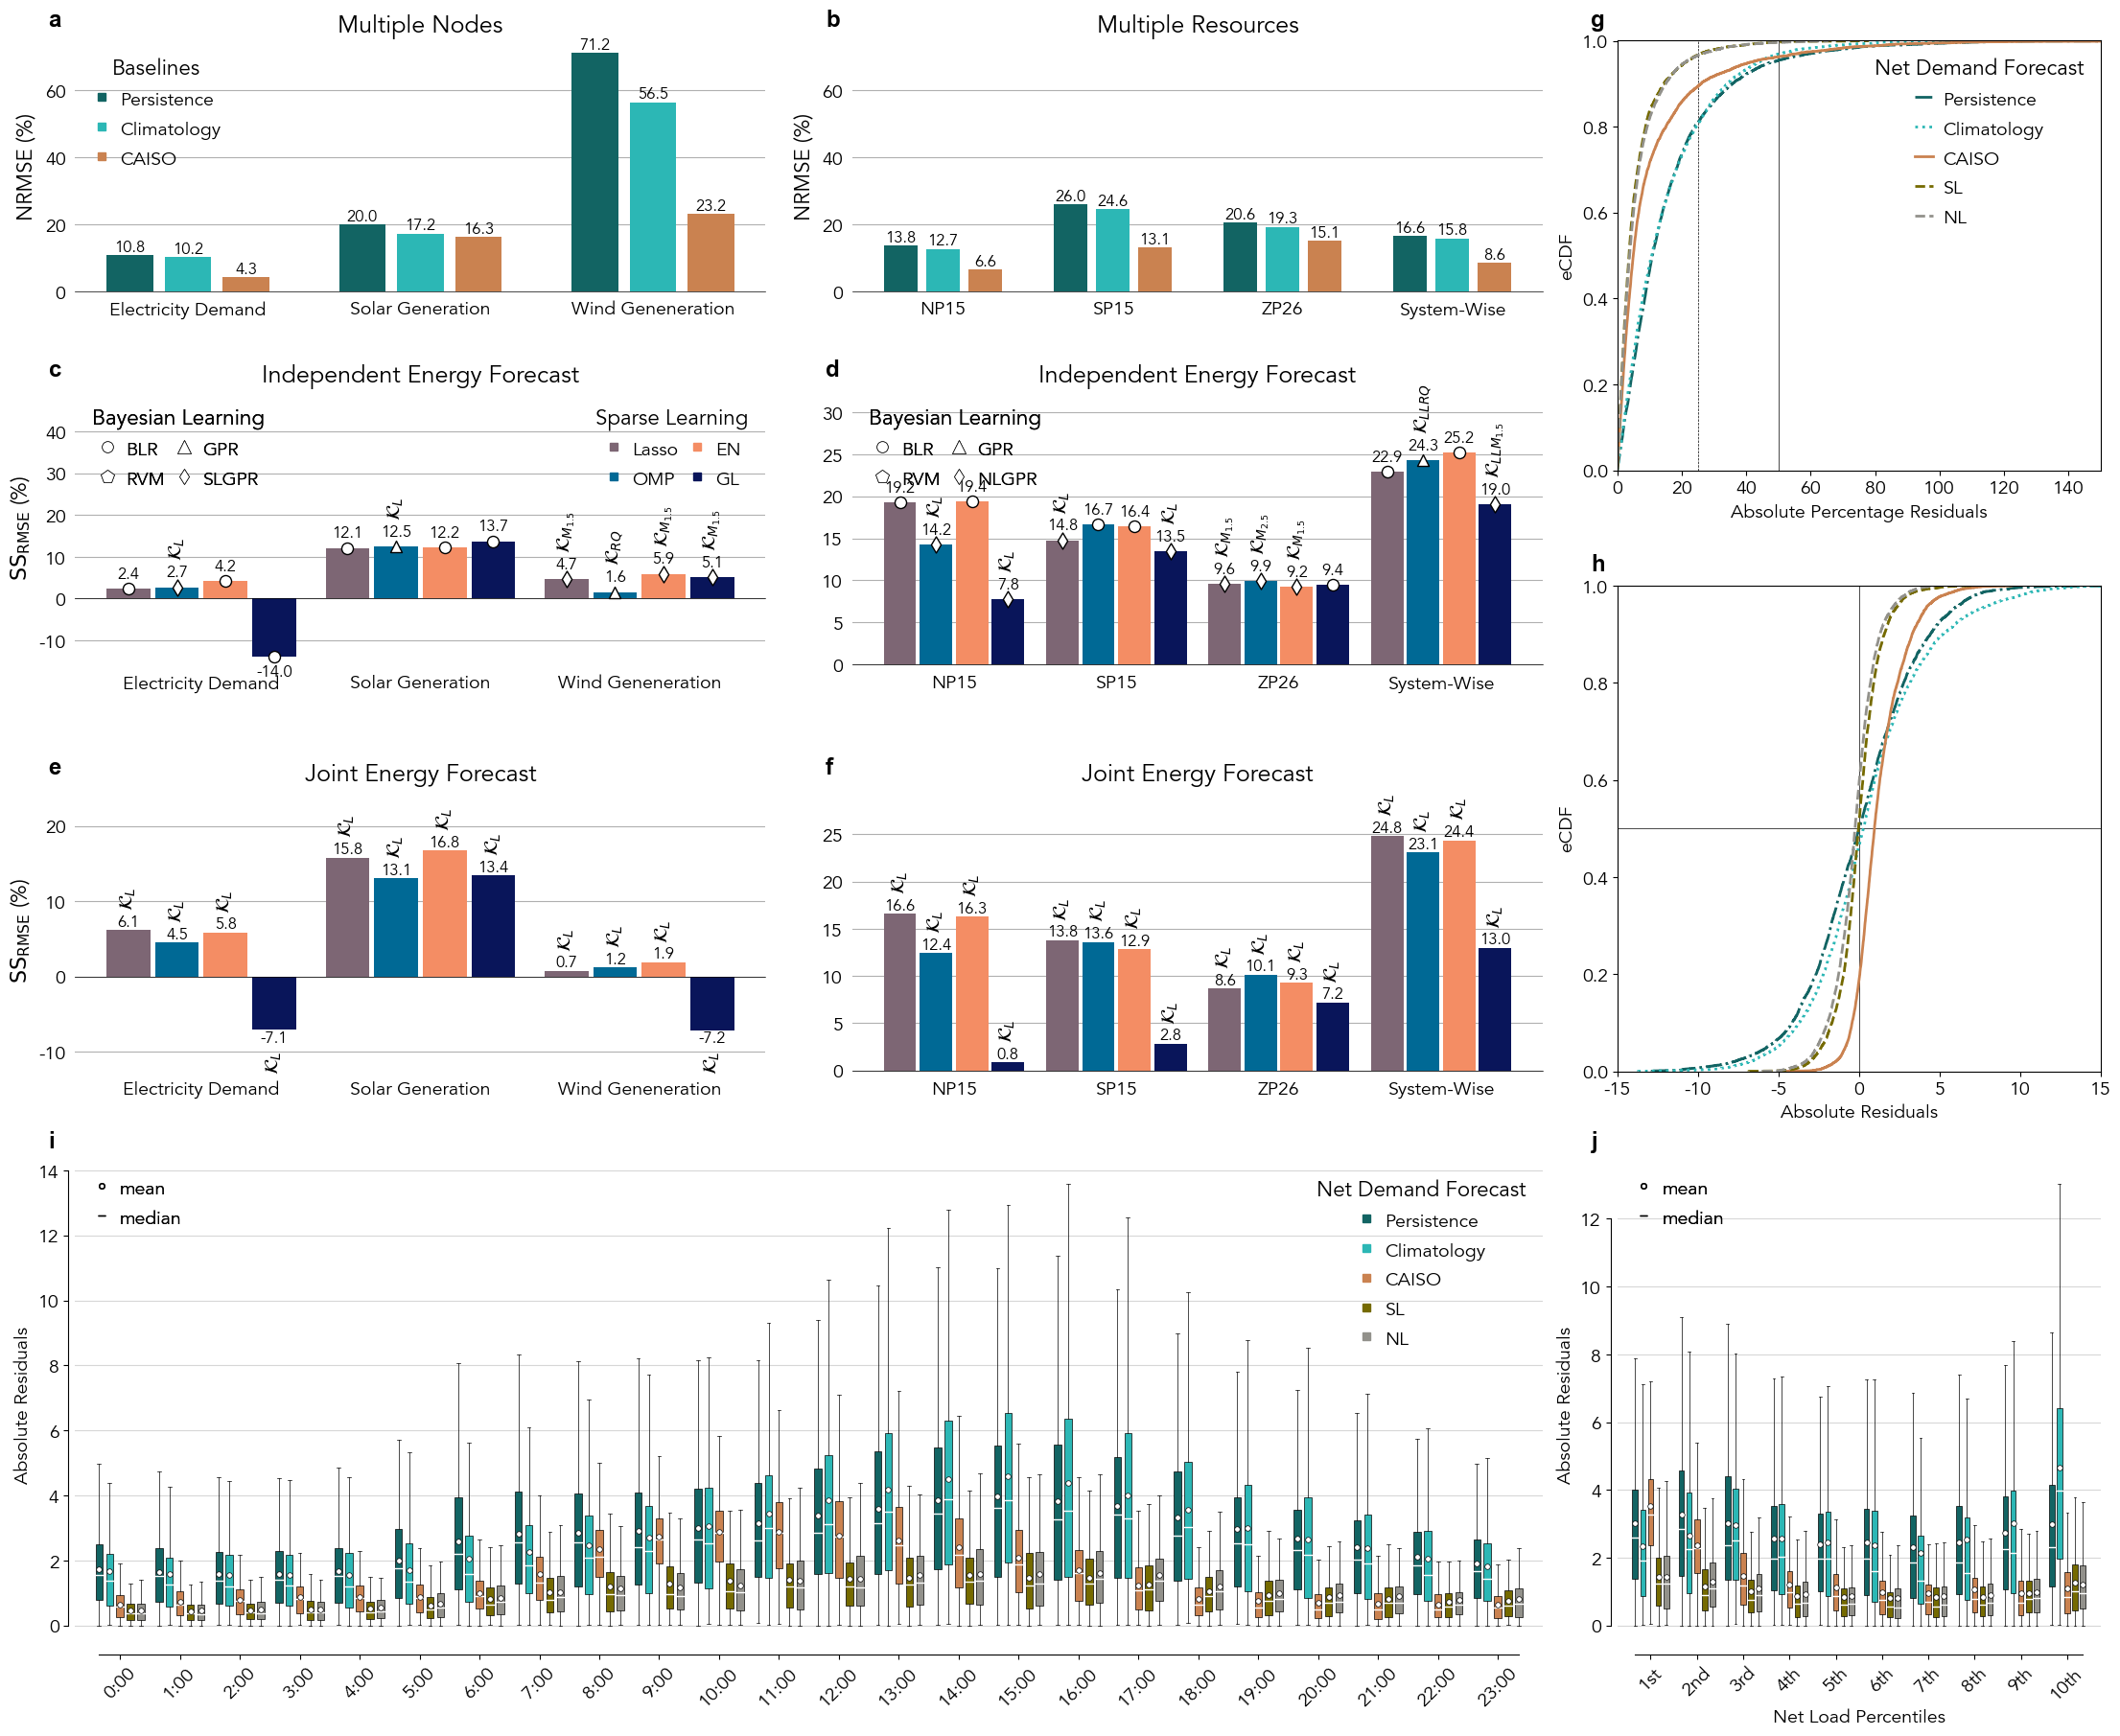

In [11]:
zones_p_ = ['Electricity Demand', 'Solar Generation', 'Wind Geneneration']
zones_   = ['NP15', 'SP15', 'ZP26', 'System-Wise']

fig, _ax = plt.subplot_mosaic([['a', 'b', 'g'], 
                               ['a', 'b', 'g'], 
                               ['c', 'd', 'g'], 
                               ['c', 'd', 'h'], 
                               ['e', 'f', 'h'], 
                               ['e', 'f', 'h'], 
                               ['i', 'i', 'j'],
                               ['i', 'i', 'j'],
                               ['i', 'i', 'j']], layout      = 'constrained', 
                                                 figsize     = (22., 18), 
                                                 gridspec_kw = {'width_ratios': [2, 2, 1.4]})

for label, ax in _ax.items():
    ax.text(0.0, 1.0, label, transform = (ax.transAxes + ScaledTranslation(-20/72, +7/72, fig.dpi_scale_trans)),
                             fontsize  = 'xx-large', 
                             weight    = "bold",
                             va        = 'bottom', 
                             family    = "Arial")

baselines_   = _baselines_MR_RMSE(_is_results)
independent_ = _independent_MR_RMSE(_is_results)
joint_       = _joint_MR_RMSE(_ms_results)

_plot_NL_baseline(_ax['b'], baselines_, zones_, colors_2_, 
                  y_min          = 0,
                  y_max          = 75,
                  score          = 'RMSE',
                  ylabel         = r'NRMSE (%)',
                  legend_labels_ = ['Persistence', 'Climatology', 'CAISO'], 
                  legend_title   = r'Baselines',
                  title          = r'Multiple Resources',
                  legend         = False)

_plot_NL_FS(_ax['d'], independent_, baselines_, zones_, colors_1_, 
            y_min          = -0.1,
            y_max          = 32.6,
            legend_labels_ = ['Lasso', 'OMP', 'EN', 'GL'], 
            legend_title   = 'Sparse Learning',
            legend         = True, 
            title          = r'Independent Energy Forecast')

_plot_NL_FS(_ax['f'], joint_, baselines_, zones_, colors_1_, 
            y_max          = 29.9,
            y_min          = -0.1,
            legend_labels_ = ['Lasso', 'OMP', 'EN', 'GL'], 
            xlabel         = '',
            legend_title   = 'Sparse Learning',
            legend         = False, 
            markers        = False,
            title          = r'Joint Energy Forecast')

baselines_   = _baselines_MN_RMSE(_is_results)
independent_ = _independent_MN_RMSE(_is_results)
joint_       = _joint_MN_RMSE(_ms_results)

_plot_SL_baseline(_ax['a'], baselines_, zones_p_, colors_2_, 
                  y_min          = 0,
                  y_max          = 75,
                  score          = 'RMSE',
                  ylabel         = r'NRMSE (%)',
                  legend_labels_ = ['Persistence', 'Climatology', 'CAISO'], 
                  title          = r'Multiple Nodes',
                  legend_title   = r'Baselines',
                  legend         = True)

_plot_SL_FS(_ax['c'], independent_, baselines_, zones_p_, colors_1_, 
            score          = 'RMSE',
            y_min          = -16,
            y_max          = 49.9,
            legend_labels_ = ['Lasso', 'OMP', 'EN', 'GL'], 
            legend_title   = 'Sparse Learning',
            ylabel         = r'$\mathrm{SS}_\mathrm{RMSE}$ (%)',
            legend         = True, 
            title          = r'Independent Energy Forecast')

_plot_SL_FS(_ax['e'], joint_, baselines_, zones_p_, colors_1_, 
            score          = 'RMSE',
            y_min          = -12.6,
            y_max          = 25,
            legend_labels_ = ['Lasso', 'OMP', 'EN', 'GL'], 
            xlabel         = '',
            legend_title   = 'Sparse Learning',
            ylabel         = r'$\mathrm{SS}_\mathrm{RMSE}$ (%)',
            legend         = False, 
            markers        = False,
            title          = r'Joint Energy Forecast')
#plt.suptitle('System-Level Energy Forecast', fontsize = 20, y = 1)

models_ = ['Persistence', 'Climatology', 'CAISO', 'SL', 'NL']

Y_, Y_per_, Y_cli_, Y_iso_ = _baselines_net(_is_results)
Y_is_hat_                  = _independent_net_RMSE(_is_results)
Y_ms_hat_                  = _joint_net_RMSE(_ms_results)


E_ = [np.absolute(Y_ - Y_per_), 
      np.absolute(Y_ - Y_cli_), 
      np.absolute(Y_ - Y_iso_), 
      np.absolute(Y_ - Y_is_hat_), 
      np.absolute(Y_ - Y_ms_hat_)]
# Y_bar_ = np.mean(Y_, axis = 0)

_plot_hourly_error(_ax['i'], models_, E_, colors_4_)

y_        = np.concatenate([Y_[:, t] for t in range(24)], axis = 0)
y_per_    = np.concatenate([Y_per_[:, t] for t in range(24)], axis = 0)
y_cli_    = np.concatenate([Y_cli_[:, t] for t in range(24)], axis = 0)
y_iso_    = np.concatenate([Y_iso_[:, t] for t in range(24)], axis = 0)
y_is_hat_ = np.concatenate([Y_is_hat_[:, t] for t in range(24)], axis = 0)
y_ms_hat_ = np.concatenate([Y_ms_hat_[:, t] for t in range(24)], axis = 0)

# e_iso_    = np.absolute(y_ - y_iso_)
# e_per_    = np.absolute(y_ - y_per_)
# e_cli_    = np.absolute(y_ - y_cli_)
# e_is_hat_ = np.absolute(y_ - y_is_hat_)
# e_ms_hat_ = np.absolute(y_ - y_ms_hat_)

e_iso_    = 100*np.absolute((y_ - y_iso_)/y_)
e_per_    = 100*np.absolute((y_ - y_per_)/y_)
e_cli_    = 100*np.absolute((y_ - y_cli_)/y_)
e_is_hat_ = 100*np.absolute((y_ - y_is_hat_)/y_)
e_ms_hat_ = 100*np.absolute((y_ - y_ms_hat_)/y_)

_plot_edf_absolute_residuals(_ax['g'], models_, [e_per_, e_cli_, e_iso_, e_is_hat_, e_ms_hat_], ['-.', ':', '-', '--', '--'], colors_4_, legend = True, x_min = -0.01)


r_iso_    = y_ - y_iso_
r_per_    = y_ - y_per_
r_cli_    = y_ - y_cli_
r_is_hat_ = y_ - y_is_hat_
r_ms_hat_ = y_ - y_ms_hat_

_plot_edf_residuals(_ax['h'], models_, [r_per_, r_cli_, r_iso_, r_is_hat_, r_ms_hat_], ['-.', ':', '-', '--', '--'], colors_4_, x_min = -15)


N_percentil = 10
N_step      = y_.shape[0]//N_percentil
idx_        = np.argsort(y_)

e_per_ = []
e_cli_ = []
e_iso_ = []
e_is_  = []
e_ms_  = []

for i in range(N_percentil):
    #y_bar_.append(np.mean(y_[idx_[i*N_step:(i + 1)*N_step]]))
    e_per_.append(np.absolute(y_[idx_[i*N_step:(i + 1)*N_step]] - y_per_[idx_[i*N_step:(i + 1)*N_step]]))
    e_cli_.append(np.absolute(y_[idx_[i*N_step:(i + 1)*N_step]] - y_cli_[idx_[i*N_step:(i + 1)*N_step]]))
    e_iso_.append(np.absolute(y_[idx_[i*N_step:(i + 1)*N_step]] - y_iso_[idx_[i*N_step:(i + 1)*N_step]]))
    e_is_.append(np.absolute(y_[idx_[i*N_step:(i + 1)*N_step]] - y_is_hat_[idx_[i*N_step:(i + 1)*N_step]]))
    e_ms_.append(np.absolute(y_[idx_[i*N_step:(i + 1)*N_step]] - y_ms_hat_[idx_[i*N_step:(i + 1)*N_step]]))

_plot_hourly_percentail(_ax['j'], models_, [e_per_, e_cli_, e_iso_, e_is_, e_ms_], colors_4_, N_percentil)

plt.savefig(path_to_images + 'baselines_v1.pdf', 
            bbox_inches = 'tight', 
            dpi         = 300)

plt.show()

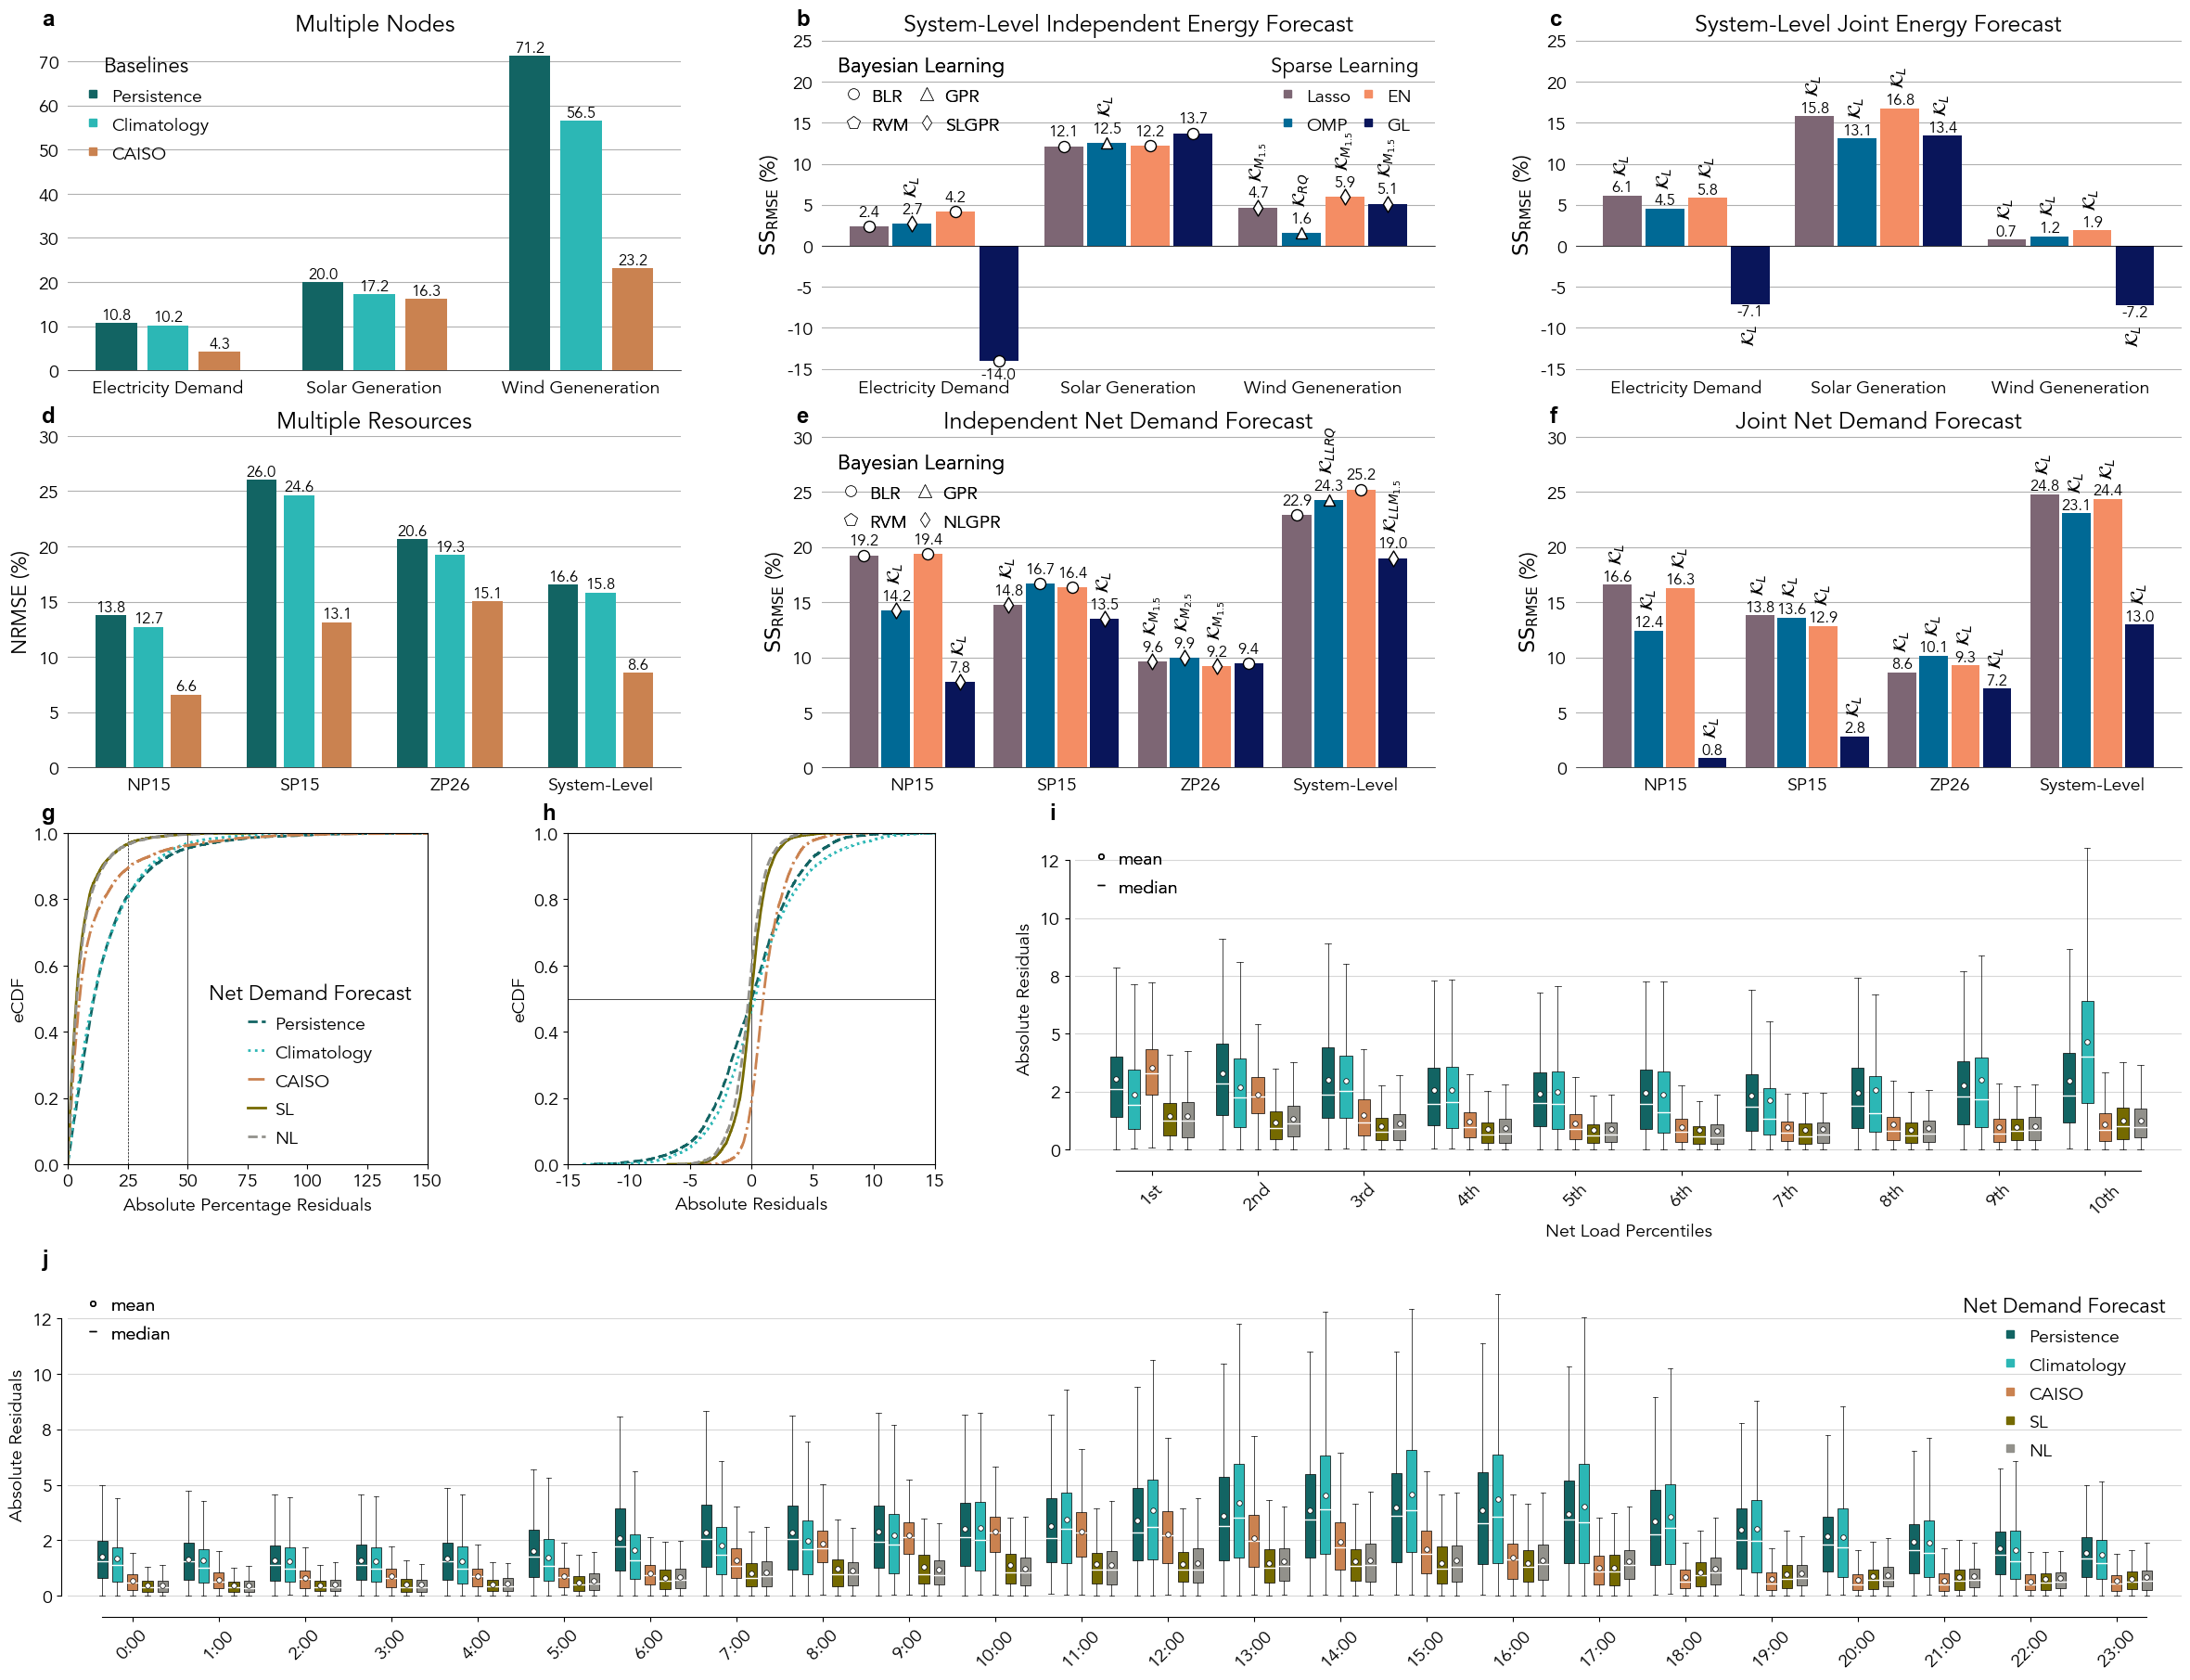

In [13]:
zones_p_ = ['Electricity Demand', 'Solar Generation', 'Wind Geneneration']
zones_   = ['NP15', 'SP15', 'ZP26', 'System-Level']

fig, _ax = plt.subplot_mosaic([['a', 'a', 'a', 'b', 'b', 'b', 'c', 'c', 'c'], 
                               ['d', 'd', 'd', 'e', 'e', 'e', 'f', 'f', 'f'], 
                               ['g', 'g', 'h', 'h', 'i', 'i', 'i', 'i', 'i'], 
                               ['j', 'j', 'j', 'j', 'j', 'j', 'j', 'j', 'j']], layout      = 'constrained', 
                                                                               figsize     = (23.5, 18))

for label, ax in _ax.items():
    ax.text(0.0, 1.0, label, transform = (ax.transAxes + ScaledTranslation(-20/72, +7/72, fig.dpi_scale_trans)),
                             fontsize  = 'xx-large', 
                             weight    = "bold",
                             va        = 'bottom', 
                             family    = "Arial")

baselines_   = _baselines_MR_RMSE(_is_results)
independent_ = _independent_MR_RMSE(_is_results)
joint_       = _joint_MR_RMSE(_ms_results)

_plot_NL_baseline(_ax['d'], baselines_, zones_, colors_2_, 
                  y_min          = 0,
                  y_max          = 30,
                  score          = 'RMSE',
                  legend_labels_ = ['Persistence', 'Climatology', 'CAISO'], 
                  legend_title   = r'Baselines',
                  title          = r'Multiple Resources',
                  ylabel         = r'NRMSE (%)',
                  legend         = False)

_plot_NL_FS(_ax['e'], independent_, baselines_, zones_, colors_1_, 
            y_min          = 0,
            y_max          = 30.1,
            legend_labels_ = ['Lasso', 'OMP', 'EN', 'GL'], 
            ylabel         = r'$\mathrm{SS}_\mathrm{RMSE}$ (%)',
            legend_title   = 'Sparse Learning',
            legend         = True, 
            title          = r'Independent Net Demand Forecast')

_plot_NL_FS(_ax['f'], joint_, baselines_, zones_, colors_1_, 
            y_max          = 30.1,
            y_min          = 0,
            legend_labels_ = ['Lasso', 'OMP', 'EN', 'GL'], 
            xlabel         = '',
            ylabel         = r'$\mathrm{SS}_\mathrm{RMSE}$ (%)',
            legend_title   = 'Sparse Learning',
            legend         = False, 
            markers        = False,
            title          = r'Joint Net Demand Forecast')

baselines_   = _baselines_MN_RMSE(_is_results)
independent_ = _independent_MN_RMSE(_is_results)
joint_       = _joint_MN_RMSE(_ms_results)

_plot_SL_baseline(_ax['a'], baselines_, zones_p_, colors_2_, 
                  y_min          = 0,
                  y_max          = 75,
                  score          = 'RMSE',
                  legend_labels_ = ['Persistence', 'Climatology', 'CAISO'], 
                  title          = r'Multiple Nodes',
                  legend_title   = r'Baselines',
                  legend         = True)

_plot_SL_FS(_ax['b'], independent_, baselines_, zones_p_, colors_1_, 
            score          = 'RMSE',
            y_min          = -15.2,
            y_max          = 25.2,
            legend_labels_ = ['Lasso', 'OMP', 'EN', 'GL'], 
            legend_title   = 'Sparse Learning',
            ylabel         = r'$\mathrm{SS}_\mathrm{RMSE}$ (%)',
            legend         = True, 
            title          = r'System-Level Independent Energy Forecast')

_plot_SL_FS(_ax['c'], joint_, baselines_, zones_p_, colors_1_, 
            score          = 'RMSE',
            y_min          = -15.2,
            y_max          = 25.2,
            legend_labels_ = ['Lasso', 'OMP', 'EN', 'GL'], 
            xlabel         = '',
            legend_title   = 'Sparse Learning',
            ylabel         = r'$\mathrm{SS}_\mathrm{RMSE}$ (%)',
            legend         = False, 
            markers        = False,
            title          = r'System-Level Joint Energy Forecast')
#plt.suptitle('System-Level Energy Forecast', fontsize = 20, y = 1)

models_ = ['Persistence', 'Climatology', 'CAISO', 'SL', 'NL']

Y_, Y_per_, Y_cli_, Y_iso_ = _baselines_net(_is_results)
Y_is_hat_                  = _independent_net_RMSE(_is_results)
Y_ms_hat_                  = _joint_net_RMSE(_ms_results)


E_ = [np.absolute(Y_ - Y_per_), 
      np.absolute(Y_ - Y_cli_), 
      np.absolute(Y_ - Y_iso_), 
      np.absolute(Y_ - Y_is_hat_), 
      np.absolute(Y_ - Y_ms_hat_)]
# Y_bar_ = np.mean(Y_, axis = 0)

_plot_hourly_error(_ax['j'], models_, E_, colors_4_)

y_        = np.concatenate([Y_[:, t] for t in range(24)], axis = 0)
y_per_    = np.concatenate([Y_per_[:, t] for t in range(24)], axis = 0)
y_cli_    = np.concatenate([Y_cli_[:, t] for t in range(24)], axis = 0)
y_iso_    = np.concatenate([Y_iso_[:, t] for t in range(24)], axis = 0)
y_is_hat_ = np.concatenate([Y_is_hat_[:, t] for t in range(24)], axis = 0)
y_ms_hat_ = np.concatenate([Y_ms_hat_[:, t] for t in range(24)], axis = 0)

e_iso_    = np.absolute(y_ - y_iso_)
e_per_    = np.absolute(y_ - y_per_)
e_cli_    = np.absolute(y_ - y_cli_)
e_is_hat_ = np.absolute(y_ - y_is_hat_)
e_ms_hat_ = np.absolute(y_ - y_ms_hat_)

e_iso_    = 100*np.absolute((y_ - y_iso_)/y_)
e_per_    = 100*np.absolute((y_ - y_per_)/y_)
e_cli_    = 100*np.absolute((y_ - y_cli_)/y_)
e_is_hat_ = 100*np.absolute((y_ - y_is_hat_)/y_)
e_ms_hat_ = 100*np.absolute((y_ - y_ms_hat_)/y_)

_plot_edf_absolute_residuals(_ax['g'], models_, [e_per_, e_cli_, e_iso_, e_is_hat_, e_ms_hat_], ['--', ':', '-.', '-', '--'], colors_4_, legend = True, x_min = -0.01)

r_iso_    = y_ - y_iso_
r_per_    = y_ - y_per_
r_cli_    = y_ - y_cli_
r_is_hat_ = y_ - y_is_hat_
r_ms_hat_ = y_ - y_ms_hat_

_plot_edf_residuals(_ax['h'], models_, [r_per_, r_cli_, r_iso_, r_is_hat_, r_ms_hat_], ['--', ':', '-.', '-', '--'], colors_4_,  x_min = -15)

N_percentil = 10
N_step      = y_.shape[0]//N_percentil
idx_        = np.argsort(y_)

e_per_ = []
e_cli_ = []
e_iso_ = []
e_is_  = []
e_ms_  = []

for i in range(N_percentil):
    #y_bar_.append(np.mean(y_[idx_[i*N_step:(i + 1)*N_step]]))
    e_per_.append(np.absolute(y_[idx_[i*N_step:(i + 1)*N_step]] - y_per_[idx_[i*N_step:(i + 1)*N_step]]))
    e_cli_.append(np.absolute(y_[idx_[i*N_step:(i + 1)*N_step]] - y_cli_[idx_[i*N_step:(i + 1)*N_step]]))
    e_iso_.append(np.absolute(y_[idx_[i*N_step:(i + 1)*N_step]] - y_iso_[idx_[i*N_step:(i + 1)*N_step]]))
    e_is_.append(np.absolute(y_[idx_[i*N_step:(i + 1)*N_step]] - y_is_hat_[idx_[i*N_step:(i + 1)*N_step]]))
    e_ms_.append(np.absolute(y_[idx_[i*N_step:(i + 1)*N_step]] - y_ms_hat_[idx_[i*N_step:(i + 1)*N_step]]))

_plot_hourly_percentail(_ax['i'], models_, [e_per_, e_cli_, e_iso_, e_is_, e_ms_], colors_4_, N_percentil)

plt.savefig(path_to_images + 'baselines_v3.pdf', bbox_inches = 'tight', 
                                                 dpi         = 300)

plt.show()

# Probabilistic Model Selection

In [76]:
# Energy Score across time
def _ES(Y_, Y_hat_):

    N_observation, N_tasks, N_horizons, N_scen = Y_hat_.shape

    score_ = np.zeros((N_observation))
    Y_     = np.concatenate([Y_[:, tsk, ...] for tsk in range(N_tasks)], axis = 1)
    Y_hat_ = np.concatenate([Y_hat_[:, tsk, ...] for tsk in range(N_tasks)], axis = 1)

    for n in range(N_observation):
        Y_p_   = np.tile(Y_[n, :], (N_scen, 1)).T
        frac1_ = np.sqrt(np.diag((Y_hat_[n, :, :] - Y_p_).T @ (Y_hat_[n, :, :] - Y_p_)))
        frac2_ = 0
        for m in range(N_scen):
            frac2_ += np.sqrt(np.sum((Y_hat_[n, :, :].T - Y_hat_[n, :, m])**2, axis = 1))
        score_[n] = (np.sum(frac1_)/N_scen) - (np.sum(frac2_)/(2*(N_scen**2)))
    return score_

# Variogram Score computed across temporal dimensions
def _VS(Y_, Y_hat_, p = .5):
    N_observation, N_tasks, N_horizons, N_scen = Y_hat_.shape
    score_ = np.zeros((N_observation))
    Y_     = np.concatenate([Y_[:, tsk, ...] for tsk in range(N_tasks)], axis = 1)
    Y_hat_ = np.concatenate([Y_hat_[:, tsk, ...] for tsk in range(N_tasks)], axis = 1)
    for n in range(N_observation):
        frac1_ = np.absolute(np.subtract.outer(Y_[n, ], Y_[n, :]))**p
        frac2_ = np.zeros((N_horizons*N_tasks, N_horizons*N_tasks))
        for m in range(N_scen):
            frac2_ += np.absolute(np.subtract.outer(Y_hat_[n, :, m], Y_hat_[n, :, m]))**p
        score_[n] = np.sum((frac1_ - (frac2_/N_scen))**2)
    return score_

def _IS(Y_, M_, S2_, z, alpha):
    
    # Interval Score
    def __IS(y_, alpha, lower_, upper_):
        score_  = (upper_ - lower_)
        score_ += (2./alpha)*(lower_ - y_) * (1*(y_ < lower_))
        score_ += (2./alpha)*(y_ - upper_) * (1*(y_ > upper_))
        return score_
    # 95% CI: z = 1.96; alpha = 0.05
    # 90% CI: z = 1.645; alpha = 0.1
    N_observation, N_horizons = M_.shape
    # Y_     = np.concatenate([Y_[:, tsk, 8:16] for tsk in [3, 4, 5]], axis = 1)
    # M_     = np.concatenate([M_[:, tsk, 8:16] for tsk in [3, 4, 5]], axis = 1)
    # S2_    = np.concatenate([S2_[:, tsk, 8:16] for tsk in [3, 4, 5]], axis = 1)
    score_ = np.zeros((N_observation,))
    for n in range(N_observation):
        score_[n] = __IS(Y_[n, :], alpha, lower_ = M_[n, :] - z*np.sqrt(S2_[n, :]),
                                          upper_ = M_[n, :] + z*np.sqrt(S2_[n, :])).sum()
    return score_

# Log Score
def _LogS(Y_, M_hat_, C_hat_):
    # Samples / Tasks / Forecasting horizons
    N_samples, N_task, N_horizons = Y_.shape
    z_ = np.zeros((N_samples,))
    for i_sample in range(N_samples):
        for i_horizon in range(N_horizons):
            z_[i_sample] += multivariate_normal(M_hat_[i_sample, :, i_horizon], C_hat_[i_sample, ..., i_horizon]).logpdf(Y_[i_sample, :, i_horizon])
    return z_

# Log Score
def _LogS(Y_, M_hat_, S2_hat_):
    # Samples / Tasks / Forecasting horizons
    N_samples, N_task, N_horizons = Y_.shape
    z_ = np.zeros((N_samples,))
    for i_sample in range(N_samples):
        for i_horizon in range(N_horizons):
            z_[i_sample] += multivariate_normal(M_hat_[i_sample, :, i_horizon], S2_hat_[i_sample, :, i_horizon]).logpdf(Y_[i_sample, :, i_horizon])
    return z_

def _RMSE(Y_, Y_hat_):
    return np.array([np.sqrt(np.mean((Y_[:, t] - Y_hat_[:, t])**2)) for t in range(Y_hat_.shape[-1])])

## Load Independent Energy Forecast Results

In [77]:
def _load_is_predictions(resources_, sl_methods_, dl_methods_, scores_, path):
    
    _results = {}
    df_      = []
    for sl_model in sl_methods_:
        print(sl_model)
        _results[sl_model] = {}
        for dl_model in dl_methods_:
            _results[sl_model][dl_model] = {}
            for score in scores_:
                _results[sl_model][dl_model][score] = {}
                
                Y_      = []
                Y_mean_ = []
                Y_var_  = []
                Y_scen_ = []
                Y_iso_  = []

                z_ = np.zeros((243,))
                tr = 0.
                ts = 0.
                thetas = r''
                for resource in resources_:
                    
                    param_ = pd.read_csv(path + f'prob_model_selection_{resource}.csv')
 
                    with open(path + '{}-{}-{}-{}.pkl'.format(resource, sl_model, dl_model, score), 'rb') as f:
                        _model = pickle.load(f)
                        
                    N_samples, N_tasks, N_horions = _model['targets'].shape
                    Z  = N_samples*N_tasks*N_horions

                    Y_.append(_model['targets'])
                    Y_mean_.append(_model['mean'])
                    Y_var_.append(_model['variance'])
                    Y_scen_.append(_model['samples'])
                    Y_iso_.append(_model['caiso'])

                    tr += _model['time'].loc['sparse_training', 'time'] + _model['time'].loc['dense_training', 'time']
                    ts += _model['time'].loc['testing', 'time'] + _model['time'].loc['prob_testing', 'time']
                    #z_ += _LogS(_model['targets'], _model['mean'], _model['variance'])
                
                    if (dl_model == 'GPR') | (dl_model == 'MTGPR'):
                        idx_   = (param_['sparse_method'] == sl_model) & (param_['dense_method'] == dl_model)
                        idx_   = idx_ & (param_['score'] == score) & (param_['resource'] == resource)
                        thetas += kernels_[int(ast.literal_eval(param_.loc[idx_ , 'parameters'].tolist()[0])[-1])]
                print(dl_model, score, thetas)
                ts = ts/N_samples
                          
                Y_      = np.concatenate(Y_, axis = 1)
                Y_mean_ = np.concatenate(Y_mean_, axis = 1)
                Y_var_  = np.concatenate(Y_var_, axis = 1)
                Y_scen_ = np.concatenate(Y_scen_, axis = 1)
                Y_iso_  = np.concatenate(Y_iso_, axis = 1)

                # _results[sl_model][dl_model][score]['mean']     = Y_mean_
                # _results[sl_model][dl_model][score]['variance'] = Y_var_
                # _results[sl_model][dl_model][score]['samples']  = Y_scen_
                
                N_      = Y_[:, 0, :] + Y_[:, 1, :] + Y_[:, 2, :] - Y_[:, 3, :] - Y_[:, 4, :] - Y_[:, 5, :] - Y_[:, 6, :] - Y_[:, 7, :] 
                N_iso_  = Y_iso_[:, 0, :] + Y_iso_[:, 1, :] + Y_iso_[:, 2, :] - Y_iso_[:, 3, :] - Y_iso_[:, 4, :] - Y_iso_[:, 5, :] - Y_iso_[:, 6, :] - Y_iso_[:, 7, :] 
                N_mean_ = Y_mean_[:, 0, :] + Y_mean_[:, 1, :] + Y_mean_[:, 2, :] - Y_mean_[:, 3, :] - Y_mean_[:, 4, :] - Y_mean_[:, 5, :] - Y_mean_[:, 6, :] - Y_mean_[:, 7, :] 
                N_var_  = Y_var_[:, 0, :] + Y_var_[:, 1, :] + Y_var_[:, 2, :] + Y_var_[:, 3, :] + Y_var_[:, 4, :] + Y_var_[:, 5, :] + Y_var_[:, 6, :] + Y_var_[:, 7, :] 

                IS975 = _IS(N_, N_mean_, N_var_, z = 2.243, alpha = 0.025).sum()/Z
                IS95  = _IS(N_, N_mean_, N_var_, z = 1.959, alpha = 0.05).sum()/Z
                IS90  = _IS(N_, N_mean_, N_var_, z = 1.645, alpha = 0.1).sum()/Z
                IS80  = _IS(N_, N_mean_, N_var_, z = 1.282, alpha = 0.2).sum()/Z
                IS60  = _IS(N_, N_mean_, N_var_, z = 0.842, alpha = 0.4).sum()/Z
                
                RMSE = _RMSE(N_, N_mean_).mean()
                FS   = 100*(1. - _RMSE(N_, N_mean_).sum()/_RMSE(N_, N_iso_).sum())
                IS   =  IS975 + IS95 + IS90 + IS80 + IS60
                #LogS = -z_.sum()/Z
                ES   = _ES(Y_, Y_scen_).sum()/Z
                VS   = _VS(Y_, Y_scen_).sum()/Z

                df_.append([sl_model, dl_model, thetas, score, RMSE, FS, ES, VS, IS, IS60, IS80, IS90, IS95, IS975, tr, ts])
    return pd.DataFrame(df_, columns = ['sparse_method', 'dense_method', 'parameters', 'score',  'RMSE',  'FS', 'ES', 'VS', 'IS', 'IS60', 'IS80', 'IS90', 'IS95', 'IS975', 'train', 'test'])

path_to_mdls = r'/Users/Guille/Desktop/caiso_power/models/journal_paper_w_sigma/'

resources_  = ['load', 'solar', 'wind']
dl_methods_ = ['BLR', 'RVM', 'GPR', 'MTGPR']
sl_methods_ = ['lasso', 'OMP', 'elastic_net', 'group_lasso']
scores_     = ['ES', 'VS', 'IS']

_is_results = _load_is_predictions(resources_, sl_methods_, dl_methods_, scores_, path_to_mdls )
print(_is_results)

lasso
BLR ES 
BLR VS 
BLR IS 
RVM ES 
RVM VS 
RVM IS 
GPR ES LLRQ
GPR VS RQRQRQ
GPR IS LLRQ
MTGPR ES LLM_{1.5}
MTGPR VS M_{1.5}LM_{1.5}
MTGPR IS LLM_{0.5}
OMP
BLR ES 
BLR VS 
BLR IS 
RVM ES 
RVM VS 
RVM IS 
GPR ES LLRQ
GPR VS RQRQRQ
GPR IS LLRQ
MTGPR ES LLM_{2.5}
MTGPR VS M_{2.5}LM_{2.5}
MTGPR IS LLL
elastic_net
BLR ES 
BLR VS 
BLR IS 
RVM ES 
RVM VS 
RVM IS 
GPR ES RQLRQ
GPR VS RQLRQ
GPR IS LLRQ
MTGPR ES LLM_{1.5}
MTGPR VS M_{1.5}LM_{1.5}
MTGPR IS LLM_{0.5}
group_lasso
BLR ES 
BLR VS 
BLR IS 
RVM ES 
RVM VS 
RVM IS 
GPR ES RQLRQ
GPR VS RQLRQ
GPR IS LLRQ
MTGPR ES LLM_{1.5}
MTGPR VS M_{1.5}LM_{1.5}
MTGPR IS LLM_{0.5}
   sparse_method dense_method       parameters score         RMSE         FS  \
0          lasso          BLR                     ES  1349.560614  22.922024   
1          lasso          BLR                     VS  1349.560614  22.922024   
2          lasso          BLR                     IS  1353.882904  22.675164   
3          lasso          RVM                     ES  15

## Load Joint Energy Forecast Results

In [78]:
def _load_ms_predictions(zones_, sl_models_, dl_models_, scores_, path):
    
    _results = {}
    df_ = []
    
    param_ = pd.read_csv(path + 'prob_model_selection_multisource.csv')

    for sl_model in sl_models_:
        print(sl_model)
        _results[sl_model] = {}
        for dl_model in dl_models_:
            _results[sl_model]['MRGPR'] = {}
            for score in scores_:
                _results[sl_model]['MRGPR'][score] = {}
                
                Y_      = []
                Y_mean_ = []
                Y_var_  = []
                Y_scen_ = []
                Y_iso_  = []
                z_ = np.zeros((243,))
                tr = 0.
                ts = 0.
                thetas = r''
                for zone in zones_:
                    with open(path + '{}-{}-{}-{}.pkl'.format(zone, sl_model, dl_model, score), 'rb') as f:
                        _model = pickle.load(f)                    

                    N_samples, N_tasks, N_horions = _model['targets'].shape
                    Z = N_samples*N_tasks*N_horions
                    
                    Y_.append(_model['targets'])
                    Y_mean_.append(_model['mean'])
                    Y_var_.append(_model['variance'])
                    Y_scen_.append(_model['samples'])
                    Y_iso_.append(_model['caiso'])
                    
                    tr += _model['time'].loc['sparse_training', 'time'] + _model['time'].loc['dense_training', 'time']
                    ts += _model['time'].loc['testing', 'time'] + _model['time'].loc['prob_testing', 'time']
                    #z_ += _LogS(_model['targets'], _model['mean'], _model['variance'])
                    
                    idx_    = (param_['sparse_method'] == sl_model) & (param_['dense_method'] == dl_model)
                    idx_    = idx_ & (param_['score'] == score) & (param_['resource'] == zone)
                    thetas += kernels_[int(ast.literal_eval(param_.loc[idx_ , 'parameters'].tolist()[0])[0][-1])]
                print(dl_model, score, thetas)
                    
                ts = ts/N_samples

                Y_      = np.concatenate(Y_, axis = 1)
                Y_mean_ = np.concatenate(Y_mean_, axis = 1)
                Y_var_  = np.concatenate(Y_var_, axis = 1)
                Y_scen_ = np.concatenate(Y_scen_, axis = 1)
                Y_iso_  = np.concatenate(Y_iso_, axis = 1)

                Y_ = np.concatenate([Y_[:, 0, ...][:, np.newaxis, ...],
                                     Y_[:, 3, ...][:, np.newaxis, ...], 
                                     Y_[:, 6, ...][:, np.newaxis, ...],
                                     Y_[:, 1, ...][:, np.newaxis, ...], 
                                     Y_[:, 4, ...][:, np.newaxis, ...], 
                                     Y_[:, 7, ...][:, np.newaxis, ...], 
                                     Y_[:, 2, ...][:, np.newaxis, ...], 
                                     Y_[:, 5, ...][:, np.newaxis, ...]], axis = 1)
                                         
                Y_scen_ = np.concatenate([Y_scen_[:, 0, ...][:, np.newaxis, ...],
                                          Y_scen_[:, 3, ...][:, np.newaxis, ...], 
                                          Y_scen_[:, 6, ...][:, np.newaxis, ...],
                                          Y_scen_[:, 1, ...][:, np.newaxis, ...], 
                                          Y_scen_[:, 4, ...][:, np.newaxis, ...], 
                                          Y_scen_[:, 7, ...][:, np.newaxis, ...], 
                                          Y_scen_[:, 2, ...][:, np.newaxis, ...], 
                                          Y_scen_[:, 5, ...][:, np.newaxis, ...]], axis = 1)

                Y_mean_ = np.concatenate([Y_mean_[:, 0, ...][:, np.newaxis, ...],
                                          Y_mean_[:, 3, ...][:, np.newaxis, ...], 
                                          Y_mean_[:, 6, ...][:, np.newaxis, ...],
                                          Y_mean_[:, 1, ...][:, np.newaxis, ...], 
                                          Y_mean_[:, 4, ...][:, np.newaxis, ...], 
                                          Y_mean_[:, 7, ...][:, np.newaxis, ...], 
                                          Y_mean_[:, 2, ...][:, np.newaxis, ...], 
                                          Y_mean_[:, 5, ...][:, np.newaxis, ...]], axis = 1)
                
                Y_var_ = np.concatenate([Y_var_[:, 0, ...][:, np.newaxis, ...],
                                         Y_var_[:, 3, ...][:, np.newaxis, ...], 
                                         Y_var_[:, 6, ...][:, np.newaxis, ...],
                                         Y_var_[:, 1, ...][:, np.newaxis, ...], 
                                         Y_var_[:, 4, ...][:, np.newaxis, ...], 
                                         Y_var_[:, 7, ...][:, np.newaxis, ...], 
                                         Y_var_[:, 2, ...][:, np.newaxis, ...], 
                                         Y_var_[:, 5, ...][:, np.newaxis, ...]], axis = 1)
                
                Y_iso_ = np.concatenate([Y_iso_[:, 0, ...][:, np.newaxis, ...],
                                         Y_iso_[:, 3, ...][:, np.newaxis, ...], 
                                         Y_iso_[:, 6, ...][:, np.newaxis, ...],
                                         Y_iso_[:, 1, ...][:, np.newaxis, ...], 
                                         Y_iso_[:, 4, ...][:, np.newaxis, ...], 
                                         Y_iso_[:, 7, ...][:, np.newaxis, ...], 
                                         Y_iso_[:, 2, ...][:, np.newaxis, ...], 
                                         Y_iso_[:, 5, ...][:, np.newaxis, ...]], axis = 1)
                
                N_      = Y_[:, 0, :] + Y_[:, 1, :] + Y_[:, 2, :] - Y_[:, 3, :] - Y_[:, 4, :] - Y_[:, 5, :] - Y_[:, 6, :] - Y_[:, 7, :] 
                N_iso_  = Y_iso_[:, 0, :] + Y_iso_[:, 1, :] + Y_iso_[:, 2, :] - Y_iso_[:, 3, :] - Y_iso_[:, 4, :] - Y_iso_[:, 5, :] - Y_iso_[:, 6, :] - Y_iso_[:, 7, :] 
                N_mean_ = Y_mean_[:, 0, :] + Y_mean_[:, 1, :] + Y_mean_[:, 2, :] - Y_mean_[:, 3, :] - Y_mean_[:, 4, :] - Y_mean_[:, 5, :] - Y_mean_[:, 6, :] - Y_mean_[:, 7, :] 
                N_var_  = Y_var_[:, 0, :] + Y_var_[:, 1, :] + Y_var_[:, 2, :] + Y_var_[:, 3, :] + Y_var_[:, 4, :] + Y_var_[:, 5, :] + Y_var_[:, 6, :] + Y_var_[:, 7, :] 
 
                # _results[sl_model]['MRGPR'][score]['mean']     = Y_mean_
                # _results[sl_model]['MRGPR'][score]['variance'] = Y_var_
                # _results[sl_model]['MRGPR'][score]['samples']  = Y_scen_
                
                IS975 = _IS(N_, N_mean_, N_var_, z = 2.243, alpha = 0.025).sum()/Z
                IS95  = _IS(N_, N_mean_, N_var_, z = 1.959, alpha = 0.05).sum()/Z
                IS90  = _IS(N_, N_mean_, N_var_, z = 1.645, alpha = 0.1).sum()/Z
                IS80  = _IS(N_, N_mean_, N_var_, z = 1.282, alpha = 0.2).sum()/Z
                IS60  = _IS(N_, N_mean_, N_var_, z = 0.842, alpha = 0.4).sum()/Z
                
                RMSE = _RMSE(N_, N_mean_).mean()
                FS   = 100*(1. - _RMSE(N_, N_mean_).sum()/_RMSE(N_, N_iso_).sum())
                IS   =  IS975 + IS95 + IS90 + IS80 + IS60
                #LogS = -z_.sum()/Z
                ES   = _ES(Y_, Y_scen_).sum()/Z
                VS   = _VS(Y_, Y_scen_).sum()/Z

                df_.append([sl_model, 'MRGPR', thetas, score, RMSE, FS, ES, VS, IS, IS60, IS80, IS90, IS95, IS975, tr, ts])
    return pd.DataFrame(df_, columns = ['sparse_method', 'dense_method', 'parameters', 'score', 'RMSE', 'FS', 'ES', 'VS', 'IS', 'IS60', 'IS80', 'IS90', 'IS95', 'IS975', 'train', 'test'])

path_to_mdls = r'/Users/Guille/Desktop/caiso_power/models/journal_paper_w_sigma_n_lambda-Cal-4/'

zones_      = ['NP15', 'SP15', 'ZP26']
dl_methods_ = ['MTGPR']
sl_methods_ = ['lasso', 'OMP', 'elastic_net', 'group_lasso']
scores_     = ['ES', 'VS', 'IS']

_ms_results = _load_ms_predictions(zones_, sl_methods_, dl_methods_, scores_, path_to_mdls)
print(_ms_results)

lasso
MTGPR ES LLL
MTGPR VS M_{1.5}M_{1.5}L
MTGPR IS LLL
OMP
MTGPR ES LLL
MTGPR VS M_{1.5}M_{1.5}L
MTGPR IS LLL
elastic_net
MTGPR ES LLL
MTGPR VS M_{1.5}M_{1.5}L
MTGPR IS LLL
group_lasso
MTGPR ES LLL
MTGPR VS LLL
MTGPR IS RQLL
   sparse_method dense_method       parameters score         RMSE         FS  \
0          lasso        MRGPR              LLL    ES  1316.500879  24.810178   
1          lasso        MRGPR  M_{1.5}M_{1.5}L    VS  1676.866066   4.228502   
2          lasso        MRGPR              LLL    IS  1334.376806  23.789223   
3            OMP        MRGPR              LLL    ES  1346.299509  23.108277   
4            OMP        MRGPR  M_{1.5}M_{1.5}L    VS  1676.024172   4.276585   
5            OMP        MRGPR              LLL    IS  1310.345767  25.161717   
6    elastic_net        MRGPR              LLL    ES  1323.912406  24.386880   
7    elastic_net        MRGPR  M_{1.5}M_{1.5}L    VS  1676.537397   4.247273   
8    elastic_net        MRGPR              LLL    IS 

In [79]:
def _load_ensemble_predictions(zones_, models_, scores_, path):
    
    _results = {}
    df_ = []
    
    param_ = pd.read_csv(path + 'prob_model_selection_multisource.csv')

    for score in scores_:
        Y_      = []
        Y_mean_ = []
        Y_var_  = []
        Y_scen_ = []
        Y_iso_  = []
        z_ = np.zeros((243,))
        tr = 0.
        ts = 0.
        thetas = r''
        for model_ in models_:

            sl_model, dl_model, zone = model_
            
#             _results[sl_model] = {}
#             _results[sl_model][dl_model] = {}
#             _results[sl_model][dl_model][score] = {}

            with open(path + '{}-{}-{}-{}.pkl'.format(zone, sl_model, dl_model, score), 'rb') as f:
                _model = pickle.load(f)                    

            N_samples, N_tasks, N_horions = _model['targets'].shape
            Z = N_samples*N_tasks*N_horions

            Y_.append(_model['targets'])
            Y_mean_.append(_model['mean'])
            Y_var_.append(_model['variance'])
            Y_scen_.append(_model['samples'])
            Y_iso_.append(_model['caiso'])

            tr += _model['time'].loc['sparse_training', 'time'] + _model['time'].loc['dense_training', 'time']
            ts += _model['time'].loc['testing', 'time'] + _model['time'].loc['prob_testing', 'time']
            #z_ += _LogS(_model['targets'], _model['mean'], _model['variance'])

            idx_    = (param_['sparse_method'] == sl_model) & (param_['dense_method'] == dl_model)
            idx_    = idx_ & (param_['score'] == score) & (param_['resource'] == zone)
            thetas += kernels_[int(ast.literal_eval(param_.loc[idx_ , 'parameters'].tolist()[0])[0][-1])]
        print(dl_model, score, thetas)

        ts = ts/N_samples

        Y_      = np.concatenate(Y_, axis = 1)
        Y_mean_ = np.concatenate(Y_mean_, axis = 1)
        Y_var_  = np.concatenate(Y_var_, axis = 1)
        Y_scen_ = np.concatenate(Y_scen_, axis = 1)
        Y_iso_  = np.concatenate(Y_iso_, axis = 1)

        Y_ = np.concatenate([Y_[:, 0, ...][:, np.newaxis, ...],
                             Y_[:, 3, ...][:, np.newaxis, ...], 
                             Y_[:, 6, ...][:, np.newaxis, ...],
                             Y_[:, 1, ...][:, np.newaxis, ...], 
                             Y_[:, 4, ...][:, np.newaxis, ...], 
                             Y_[:, 7, ...][:, np.newaxis, ...], 
                             Y_[:, 2, ...][:, np.newaxis, ...], 
                             Y_[:, 5, ...][:, np.newaxis, ...]], axis = 1)

        Y_scen_ = np.concatenate([Y_scen_[:, 0, ...][:, np.newaxis, ...],
                                  Y_scen_[:, 3, ...][:, np.newaxis, ...], 
                                  Y_scen_[:, 6, ...][:, np.newaxis, ...],
                                  Y_scen_[:, 1, ...][:, np.newaxis, ...], 
                                  Y_scen_[:, 4, ...][:, np.newaxis, ...], 
                                  Y_scen_[:, 7, ...][:, np.newaxis, ...], 
                                  Y_scen_[:, 2, ...][:, np.newaxis, ...], 
                                  Y_scen_[:, 5, ...][:, np.newaxis, ...]], axis = 1)

        Y_mean_ = np.concatenate([Y_mean_[:, 0, ...][:, np.newaxis, ...],
                                  Y_mean_[:, 3, ...][:, np.newaxis, ...], 
                                  Y_mean_[:, 6, ...][:, np.newaxis, ...],
                                  Y_mean_[:, 1, ...][:, np.newaxis, ...], 
                                  Y_mean_[:, 4, ...][:, np.newaxis, ...], 
                                  Y_mean_[:, 7, ...][:, np.newaxis, ...], 
                                  Y_mean_[:, 2, ...][:, np.newaxis, ...], 
                                  Y_mean_[:, 5, ...][:, np.newaxis, ...]], axis = 1)

        Y_var_ = np.concatenate([Y_var_[:, 0, ...][:, np.newaxis, ...],
                                 Y_var_[:, 3, ...][:, np.newaxis, ...], 
                                 Y_var_[:, 6, ...][:, np.newaxis, ...],
                                 Y_var_[:, 1, ...][:, np.newaxis, ...], 
                                 Y_var_[:, 4, ...][:, np.newaxis, ...], 
                                 Y_var_[:, 7, ...][:, np.newaxis, ...], 
                                 Y_var_[:, 2, ...][:, np.newaxis, ...], 
                                 Y_var_[:, 5, ...][:, np.newaxis, ...]], axis = 1)

        Y_iso_ = np.concatenate([Y_iso_[:, 0, ...][:, np.newaxis, ...],
                                 Y_iso_[:, 3, ...][:, np.newaxis, ...], 
                                 Y_iso_[:, 6, ...][:, np.newaxis, ...],
                                 Y_iso_[:, 1, ...][:, np.newaxis, ...], 
                                 Y_iso_[:, 4, ...][:, np.newaxis, ...], 
                                 Y_iso_[:, 7, ...][:, np.newaxis, ...], 
                                 Y_iso_[:, 2, ...][:, np.newaxis, ...], 
                                 Y_iso_[:, 5, ...][:, np.newaxis, ...]], axis = 1)

        N_      = Y_[:, 0, :] + Y_[:, 1, :] + Y_[:, 2, :] - Y_[:, 3, :] - Y_[:, 4, :] - Y_[:, 5, :] - Y_[:, 6, :] - Y_[:, 7, :] 
        N_iso_  = Y_iso_[:, 0, :] + Y_iso_[:, 1, :] + Y_iso_[:, 2, :] - Y_iso_[:, 3, :] - Y_iso_[:, 4, :] - Y_iso_[:, 5, :] - Y_iso_[:, 6, :] - Y_iso_[:, 7, :] 
        N_mean_ = Y_mean_[:, 0, :] + Y_mean_[:, 1, :] + Y_mean_[:, 2, :] - Y_mean_[:, 3, :] - Y_mean_[:, 4, :] - Y_mean_[:, 5, :] - Y_mean_[:, 6, :] - Y_mean_[:, 7, :] 
        N_var_  = Y_var_[:, 0, :] + Y_var_[:, 1, :] + Y_var_[:, 2, :] + Y_var_[:, 3, :] + Y_var_[:, 4, :] + Y_var_[:, 5, :] + Y_var_[:, 6, :] + Y_var_[:, 7, :] 

        # _results[sl_model]['MRGPR'][score]['mean']     = Y_mean_
        # _results[sl_model]['MRGPR'][score]['variance'] = Y_var_
        # _results[sl_model]['MRGPR'][score]['samples']  = Y_scen_

        IS975 = _IS(N_, N_mean_, N_var_, z = 2.243, alpha = 0.025).sum()/Z
        IS95  = _IS(N_, N_mean_, N_var_, z = 1.959, alpha = 0.05).sum()/Z
        IS90  = _IS(N_, N_mean_, N_var_, z = 1.645, alpha = 0.1).sum()/Z
        IS80  = _IS(N_, N_mean_, N_var_, z = 1.282, alpha = 0.2).sum()/Z
        IS60  = _IS(N_, N_mean_, N_var_, z = 0.842, alpha = 0.4).sum()/Z

        RMSE = _RMSE(N_, N_mean_).mean()
        FS   = 100*(1. - _RMSE(N_, N_mean_).sum()/_RMSE(N_, N_iso_).sum())
        IS   =  IS975 + IS95 + IS90 + IS80 + IS60
        #LogS = -z_.sum()/Z
        ES   = _ES(Y_, Y_scen_).sum()/Z
        VS   = _VS(Y_, Y_scen_).sum()/Z

        df_.append([sl_model, 'MRGPR', thetas, score, RMSE, FS, ES, VS, IS, IS60, IS80, IS90, IS95, IS975, tr, ts])
    return pd.DataFrame(df_, columns = ['sparse_method', 'dense_method', 'parameters', 'score', 'RMSE', 'FS', 'ES', 'VS', 'IS', 'IS60', 'IS80', 'IS90', 'IS95', 'IS975', 'train', 'test'])

path_to_mdls = r'/Users/Guille/Desktop/caiso_power/models/journal_paper_w_sigma_n_lambda-Cal-4/'

scores_ = ['ES']
models_ = [['elastic_net', 'MTGPR', 'NP15'], ['lasso', 'MTGPR', 'SP15'], ['OMP', 'MTGPR', 'ZP26']]

_ensemble_results = _load_ensemble_predictions(zones_, models_, scores_, path_to_mdls)
print(_ensemble_results)

scores_ = ['ES']
models_ = [['lasso', 'MTGPR', 'NP15'], ['lasso', 'MTGPR', 'SP15'], ['lasso', 'MTGPR', 'ZP26']]

_ensemble_results = _load_ensemble_predictions(zones_, models_, scores_, path_to_mdls)
print(_ensemble_results)

scores_ = ['ES']
models_ = [['OMP', 'MTGPR', 'NP15'], ['OMP', 'MTGPR', 'SP15'], ['OMP', 'MTGPR', 'ZP26']]

_ensemble_results = _load_ensemble_predictions(zones_, models_, scores_, path_to_mdls)
print(_ensemble_results)

MTGPR ES LLL
  sparse_method dense_method parameters score         RMSE         FS  \
0           OMP        MRGPR        LLL    ES  1308.982938  25.239553   

          ES            VS            IS         IS60         IS80  \
0  85.494713  21884.858822  13911.780364  1837.963444  2342.239416   

          IS90         IS95        IS975         train       test  
0  2804.040613  3247.360188  3680.176704  11213.354534  24.388817  
MTGPR ES LLL
  sparse_method dense_method parameters score         RMSE         FS  \
0         lasso        MRGPR        LLL    ES  1316.500879  24.810178   

          ES            VS            IS         IS60         IS80  \
0  85.341738  21800.450008  14016.984071  1848.794687  2358.599975   

          IS90         IS95        IS975         train       test  
0  2820.637331  3278.285273  3710.666805  10817.476656  24.467765  
MTGPR ES LLL
  sparse_method dense_method parameters score         RMSE         FS  \
0           OMP        MRGPR        LLL 

In [80]:
dl_methods_ = ['BLR', 'RVM', 'GPR', 'MNGPR', 'MRGPR']
sl_methods_ = ['lasso', 'OMP', 'elastic_net', 'group_lasso']
ts_scores_ = pd.concat([_is_results, _ms_results], axis = 0).reset_index(drop = True)
ts_scores_.loc[ts_scores_['dense_method'] == 'MTGPR', 'dense_method'] = 'MNGPR'
print(ts_scores_.loc[ts_scores_['score'] == 'IS'])

   sparse_method dense_method parameters score         RMSE         FS  \
2          lasso          BLR               IS  1353.882904  22.675164   
5          lasso          RVM               IS  1659.141085   5.240835   
8          lasso          GPR       LLRQ    IS  1378.939316  21.244107   
11         lasso        MNGPR  LLM_{0.5}    IS  1408.206039  19.572585   
14           OMP          BLR               IS  1359.821268  22.336004   
17           OMP          RVM               IS  1344.739367  23.197382   
20           OMP          GPR       LLRQ    IS  1361.584078  22.235323   
23           OMP        MNGPR        LLL    IS  1318.159186  24.715466   
26   elastic_net          BLR               IS  1306.227447  25.396928   
29   elastic_net          RVM               IS  1424.865406  18.621113   
32   elastic_net          GPR       LLRQ    IS  1348.566442  22.978805   
35   elastic_net        MNGPR  LLM_{0.5}    IS  1411.510796  19.383840   
38   group_lasso          BLR         

## Energy Forecast Model Selection

In [107]:
def _plot_results(ax, ts_scores_, sl_models_, dl_models_, score, criteria, colors_, 
                  units        = 1.,
                  y_min        = 0., 
                  y_max        = 0., 
                  legend_labels_ = [],
                  suptitle     = '', 
                  title        = '', 
                  legend_title = '', 
                  letter       = '',
                  legend       = False, 
                  decimals     = False):

    markers_ = ['o', 'p', '^', 'd', 'h']

    width  = 0.15
    offset = 1.

    x_ = np.linspace(0, width*len(sl_models_), len(sl_models_))

    ticks_ = []
    j = 0

    for dl_model in dl_models_:

        i = 0
        y_ = []
        for sl_model in sl_models_:

            idx_1_ = (ts_scores_['score'] == criteria)
            idx_2_ = (ts_scores_['sparse_method'] == sl_model) & (ts_scores_['dense_method'] == dl_model)

            y_.append(ts_scores_.loc[idx_1_ & idx_2_, score].min())
            #print(score, dl_model, sl_model, ts_scores_.loc[idx_1_ & idx_2_, score].min())
            if ts_scores_.loc[idx_1_, score].min() == ts_scores_.loc[idx_1_ & idx_2_, score].min():
                if score == criteria:
                    ax.scatter(x_[i], y_[-1]/units, marker = markers_[j], s = 175, edgecolor = 'k', lw = 1., color = colors_[i], zorder = 10)
                else:
                    ax.scatter(x_[i], y_[-1]/units, marker = markers_[j], s = 175, edgecolor = 'w', lw = .5, color = colors_[i], zorder = 10)
            else:
                ax.scatter(x_[i], y_[-1]/units, marker = markers_[j], s = 85, edgecolor = 'w', lw = .5, color = colors_[i], zorder = 10)

            i +=1 
        #ax.plot(x_, y_, lw = 1., zorder = 9, marker = '.', color = 'k')
        j += 1
        ticks_.append(x_.mean())
        x_ += offset

    ax.xaxis.set_tick_params(labelsize = 14)
    ax.yaxis.set_tick_params(labelsize = 14)
    ax.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))

    if decimals: ax.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.2f}'))

    ax.spines[['right', 'top', 'left', 'bottom']].set_visible(False)

    ax.set_ylabel(score, fontsize = 16)
    # plt.xlabel(xlabel, fontsize = 16)

    dl_models_p_ = ['BLR', 'RVM', 'GPR', 'SLGPR', 'NLGPR']
    ax.set_xticks(ticks_[:len(dl_models_)], dl_models_p_, fontsize = 18)

    ax.set_ylim(y_min, y_max)

    legend_ = []
    for i in range(len(legend_labels_)):
        legend_.append(Line2D([0], [0], marker          = 's', 
                                        markerfacecolor = colors_[i], 
                                        markeredgecolor = colors_[i], 
                                        markersize      = 6,
                                        label           = legend_labels_[i],
                                        color           = "None"))
    if legend:
        _leg_1 = plt.legend(handles        = legend_, 
                            title          = legend_title, 
                            prop           = {'size': 12}, 
                            title_fontsize = 14,
                            ncol           = 1, 
                            columnspacing  = 0., 
                            handletextpad  = 0.,  
                            bbox_to_anchor = [.975, .8],
                            frameon        = False)
        ax.add_artist(_leg_1)


    legend_ = []

    legend_.append(Line2D([0], [0], marker          = 'o', 
                                    markerfacecolor = None, 
                                    markeredgecolor = 'k', 
                                    markersize      = 4,
                                    label           = 'median',
                                    color           = "None"))

    legend_.append(Line2D([0], [0], marker          = '_', 
                                    markerfacecolor = "silver", 
                                    markeredgecolor = "silver", 
                                    markersize      = 6,
                                    label           = 'mean',
                                    color           = "None"))
    if legend:
        _leg_2 = plt.legend(handles        = legend_, 
                            prop           = {'size': 14}, 
                            title_fontsize = 14,
                            ncol           = 1, 
                            columnspacing  = 0., 
                            handletextpad  = 0.,  
                            bbox_to_anchor = [0.35, .65],
                            #loc            = 'upper left',
                            frameon        = False)

        ax.add_artist(_leg_2)
    
    ax.grid(axis      = 'y', 
            alpha     = .5, 
            linestyle = '-')
    
def _plot_time(ax, time_, sl_models_, dl_models_, score, colors_, 
               legend   = True, 
               y_min    = 1, 
               x_max    = 1):

    markers_       = ['o', 'p', '^', 'd', 'h']
    legend_labels_ = ['Lasso', 'OMP', 'Elastic Net', 'Group Lasso']

    idx_1_ = (time_['score'] == score)

    time_['train'] = time_['train'].astype(float)
    time_['test']  = time_['test'].astype(float)
    
    zorder_ = [9, 10, 8, 7]

    i = 0
    for sl_method in sl_models_:

        idx_2_ = time_['sparse_method'] == sl_method

        j = 0
        for dl_method in dl_models_:

            idx_3_ = time_['dense_method'] == dl_method

            time_p_ = time_.loc[idx_1_ & idx_2_ & idx_3_]

            if j == 0:
                ax.scatter(time_p_['test'], time_p_['train'], s         = 300., 
                                                              marker    = markers_[j], 
                                                              edgecolor = 'k',
                                                              lw        = .5, 
                                                              alpha     = 0.75,
                                                              facecolor = colors_[i], 
                                                              clip_on   = False, zorder = zorder_[i])
            else:
                ax.scatter(time_p_['test'], time_p_['train'], s         = 300., 
                                                              marker    = markers_[j], 
                                                              edgecolor = 'k',
                                                              lw        = .5, 
                                                              alpha     = 0.75,
                                                              facecolor = colors_[i], 
                                                              clip_on   = False, zorder = zorder_[i])
            j += 1
        i +=1

    ax.spines[['right', 'top']].set_visible(False)

    ax.set_xscale('symlog')
    ax.set_yscale('symlog')

    ax.xaxis.set_tick_params(labelsize = 14)
    ax.yaxis.set_tick_params(labelsize = 14)

    ax.yaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}'))
    ax.yaxis.set_minor_formatter(NullFormatter())

    ax.xaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}'))
    ax.xaxis.set_minor_formatter(NullFormatter())

    ax.set_ylabel('Training Time (s)', fontsize = 16)
    ax.set_xlabel('Testing Time (s)', fontsize = 16)

    legend_title = "Sparse Learning"

    legend_ = []
    for i in range(len(legend_labels_)):
        legend_.append(Line2D([0], [0], marker          = 's', 
                                        markerfacecolor = colors_[i], 
                                        markeredgecolor = "k", 
                                        markersize      = 10,
                                        markeredgewidth = .5,
                                        label           = legend_labels_[i],
                                        color           = "None"))
    if legend:
        _leg_1 = plt.legend(handles        = legend_, 
                            title          = legend_title, 
                            prop           = {'size': 14}, 
                            title_fontsize = 16,
                            ncol           = 1, 
                            columnspacing  = 0.5, 
                            handletextpad  = 0.25,  
                            bbox_to_anchor = [1.05, .66],
                            frameon        = False)
        ax.add_artist(_leg_1)

    dl_models_p_ = ['BLR', 'RVM', 'GPR', 'SLGPR', 'NLGPR']

    legend_ = []
    for dl_model, marker in zip(dl_models_p_, markers_):
        legend_.append(Line2D([0], [0], marker          = marker, 
                                        markerfacecolor = 'None', 
                                        color           = "None",
                                        markeredgecolor = 'k', 
                                        markersize      = 15,
                                        markeredgewidth = .5,
                                        label           = dl_model))

    if legend:
        _leg_2 = ax.legend(handles        = legend_, 
                            prop           = {'size': 12}, 
                            title_fontsize = 14,
                            ncol           = 5, 
                            columnspacing  = 0.5, 
                            handletextpad  = 0.25,  
                            bbox_to_anchor = [1., .125],
                            frameon        = False)
        ax.add_artist(_leg_2)

    ax.set_ylim(10, 100000)
    ax.set_xlim(1, x_max)
    
    
def _plot_FS(ax, Scores_, sparse_methods_, dense_methods_, zones_, colors_, 
             score          = 'RMSE',
             legend_labels_ = [], 
             legend_title   = '', 
             xlabel         = '',
             ylabel         = '', 
             legend         = False,
             y_min          = -5, 
             y_max          = 15):

    x_ = np.linspace(0, .333*len(sparse_methods_), len(sparse_methods_))

    width  = 0.4
    offset = 2.

    ticks_  = []
    values_ = []
    j = 0

    for dense_method in dense_methods_:
        i = 0
        for sparse_method in sparse_methods_:
            idx_1_ = (Scores_['sparse_method'] == sparse_method) & (Scores_['dense_method'] == dense_method)
            idx_2_ = (Scores_['score'] == score)


                
            p = ax.bar(x_[i], Scores_.loc[idx_1_ & idx_2_, 'FS'].min(), width, color  = colors_[i], 
                                                                               zorder = 9, 
                                                                               align  = 'center')
                
                
            params = Scores_.loc[idx_1_ & idx_2_, 'parameters'].tolist()[0]
            #print(params)
            kernel = ''
            fontsize = 12
            if params != '':
                params1 = r'$\mathcal{K}_{' + f'{params}' + '}$'
                kernel = f'{params1}'
                
                ax.bar_label(p, labels = [f'{x:,.1f}' for x in p.datavalues], size = 12)
                ax.bar_label(p, labels = [kernel for x in p.datavalues], size = 12, rotation = 90, padding = 15)
                
            else:
                ax.bar_label(p, labels = [f'{x:,.1f}' for x in p.datavalues], size = 12)
           
            i += 1
        
        ticks_.append(x_.mean())

        x_ += offset
        j  += 1
 
        
    ax.set_ylim(y_min, y_max)

    legend_ = []
    for i in range(len(legend_labels_)):
        legend_.append(Line2D([0], [0], marker          = 's', 
                                        markerfacecolor = colors_[i], 
                                        markeredgecolor = colors_[i], 
                                        markersize      = 6,
                                        label           = legend_labels_[i],
                                        color           = "None"))
    if legend:
        ax.legend(handles        = legend_, 
                   title          = legend_title, 
                   prop           = {'size': 14}, 
                   title_fontsize = 16,
                   ncol           = 1, 
                   columnspacing  = 0., 
                   handletextpad  = 0.,  
                   bbox_to_anchor = [1., .9],
                   frameon        = False)

    
    ax.grid(axis = 'y')

    ax.xaxis.set_tick_params(labelsize = 14, left = False)
    ax.yaxis.set_tick_params(labelsize = 14, left = False)
    
    ax.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))

    ax.spines[['right', 'top', 'left', 'bottom']].set_visible(False)
    
    dl_models_p_ = ['BLR', 'RVM', 'GPR', 'SLGPR', 'NLGPR']

    ax.set_ylabel(ylabel, fontsize = 16)
    ax.set_xlabel(xlabel, fontsize = 16)
    ax.set_xticks(ticks_[:len(dense_methods_)], dl_models_p_, fontsize = 14)

    ax.axhline(0, linewidth = .5, 
                  linestyle = '-', 
                  color     = 'k', 
                  clip_on   = False, 
                  zorder    = 10)

### Energy Forecast Model Selection - Energy Score

In [108]:
# fig, _ax = plt.subplots()


# _plot_time(_ax, ts_scores_, sl_methods_, dl_methods_, score    = criteria, 
#                                                       colors_  = colors_1_, 
#                                                       legend   = True, 
#                                                       x_max    = 100)


# # plt.savefig(path_to_images + f'caiso_model_selection_{criteria}.pdf', bbox_inches = 'tight',
# #                                                                       dpi         = 300)
# plt.show()

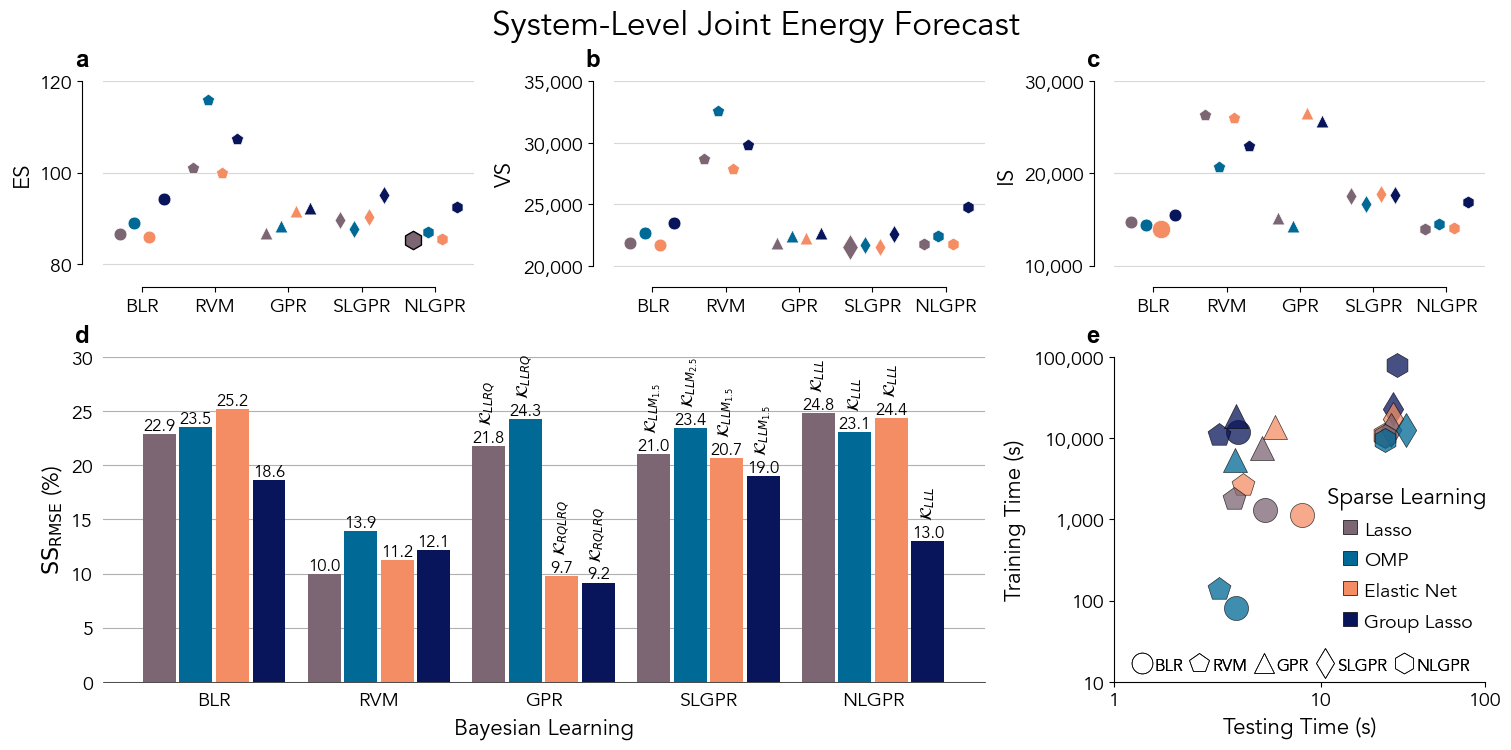

In [113]:
criteria = 'ES'

fig, _ax = plt.subplot_mosaic([['a', 'b', 'c'], ['d', 'd', 'e']], layout  = 'constrained', 
                                                                  figsize = (15, 7), 
                                                                  gridspec_kw = {'height_ratios': [1, 1.75]})

for label, ax in _ax.items():
    ax.text(0.0, 1.0, label, transform = (ax.transAxes + ScaledTranslation(-20/72, +7/72, fig.dpi_scale_trans)),
                             fontsize  = 'xx-large', 
                             weight    = "bold",
                             va        = 'bottom',
                             family    = 'Arial')

_plot_results(_ax['a'], ts_scores_, sl_methods_, dl_methods_, criteria       = criteria,
                                                              score          = 'ES', 
                                                              y_min          = 79.5, 
                                                              y_max          = 120, 
                                                              legend_labels_ = ['Lasso', 'OMP', 'Elastic Net', 'Group Lasso'],
                                                              colors_        = colors_1_,
                                                              legend_title   = 'Sparse Learning', 
                                                              legend         = False, 
                                                              decimals       = False)

#_ax['b'].set_title('Energy Forecast', fontsize = 18, y = 1.)

sns.despine(trim   = True, 
            offset = 15,
            ax     = _ax['a'])

_plot_results(_ax['b'], ts_scores_, sl_methods_, dl_methods_, criteria       = criteria,
                                                              score          = 'VS', 
                                                              y_min          = 19950, 
                                                              y_max          = 35000, 
                                                              legend_labels_ = ['Lasso', 'OMP', 'Elastic Net', 'Group Lasso'],
                                                              colors_        = colors_1_,
                                                              legend_title   = 'Sparse Learning', 
                                                              legend         = False, 
                                                              decimals       = False)

sns.despine(trim   = True, 
            offset = 15, 
            ax     = _ax['b'])

_plot_results(_ax['c'], ts_scores_, sl_methods_, dl_methods_, criteria       = criteria,
                                                              score          = 'IS', 
                                                              y_min          = 9900, 
                                                              y_max          = 30000, 
                                                              legend_labels_ = ['Lasso', 'OMP', 'Elastic Net', 'Group Lasso'],
                                                              colors_        = colors_1_,
                                                              legend_title   = 'Sparse Learning', 
                                                              legend         = False, 
                                                              decimals       = False)

sns.despine(trim   = True, 
            offset = 15, 
            ax     = _ax['c'])

plt.suptitle('System-Level Joint Energy Forecast', fontsize = 24, y = 1.05)


_plot_FS(_ax['d'], ts_scores_, sl_methods_, dl_methods_, zones_, colors_        = colors_1_, 
                                                                 score          = criteria,
                                                                 legend_labels_ = ['Lasso', 'OMP', 'Elastic Net', 'Group Lasso'], 
                                                                 xlabel         = 'Bayesian Learning',
                                                                 ylabel         = r'$\mathrm{SS}_{\mathrm{RMSE}}$ (%)',
                                                                 legend_title   = 'Sparse Learning',
                                                                 legend         = False, 
                                                                 y_min          = 0., 
                                                                 y_max          = 30)

_plot_time(_ax['e'], ts_scores_, sl_methods_, dl_methods_, score    = criteria, 
                                                           colors_  = colors_1_, 
                                                           legend   = True, 
                                                           x_max    = 100)


plt.savefig(path_to_images + f'caiso_model_selection_{criteria}.pdf', bbox_inches = 'tight',
                                                                      dpi         = 300)

plt.show()

### Energy Forecast Model Selection - Variogram Score

ES BLR lasso 87.13584229489808
ES BLR OMP 88.44479096318256
ES BLR elastic_net 85.70525683468857
ES BLR group_lasso 89.02441625251028
ES RVM lasso 101.26115680302945
ES RVM OMP 115.68721027745026
ES RVM elastic_net 100.4725565780012
ES RVM group_lasso 109.18771481279055
ES GPR lasso 103.78720333106412
ES GPR OMP 106.63461237290575
ES GPR elastic_net 91.80452486782302
ES GPR group_lasso 96.5098535342569
ES MNGPR lasso 101.80919310880195
ES MNGPR OMP 100.41444353917983
ES MNGPR elastic_net 119.02116254732118
ES MNGPR group_lasso 97.7935623442841
ES MRGPR lasso 110.02542991200791
ES MRGPR OMP 108.7813319056098
ES MRGPR elastic_net 109.41711869684224
ES MRGPR group_lasso 92.59706945660464
VS BLR lasso 21954.653587003428
VS BLR OMP 22453.325097983743
VS BLR elastic_net 21628.457639544387
VS BLR group_lasso 22442.481537149193
VS RVM lasso 28774.84496560349
VS RVM OMP 32517.354783914314
VS RVM elastic_net 28395.373708687865
VS RVM group_lasso 30211.637295635723
VS GPR lasso 25215.52269924
VS 

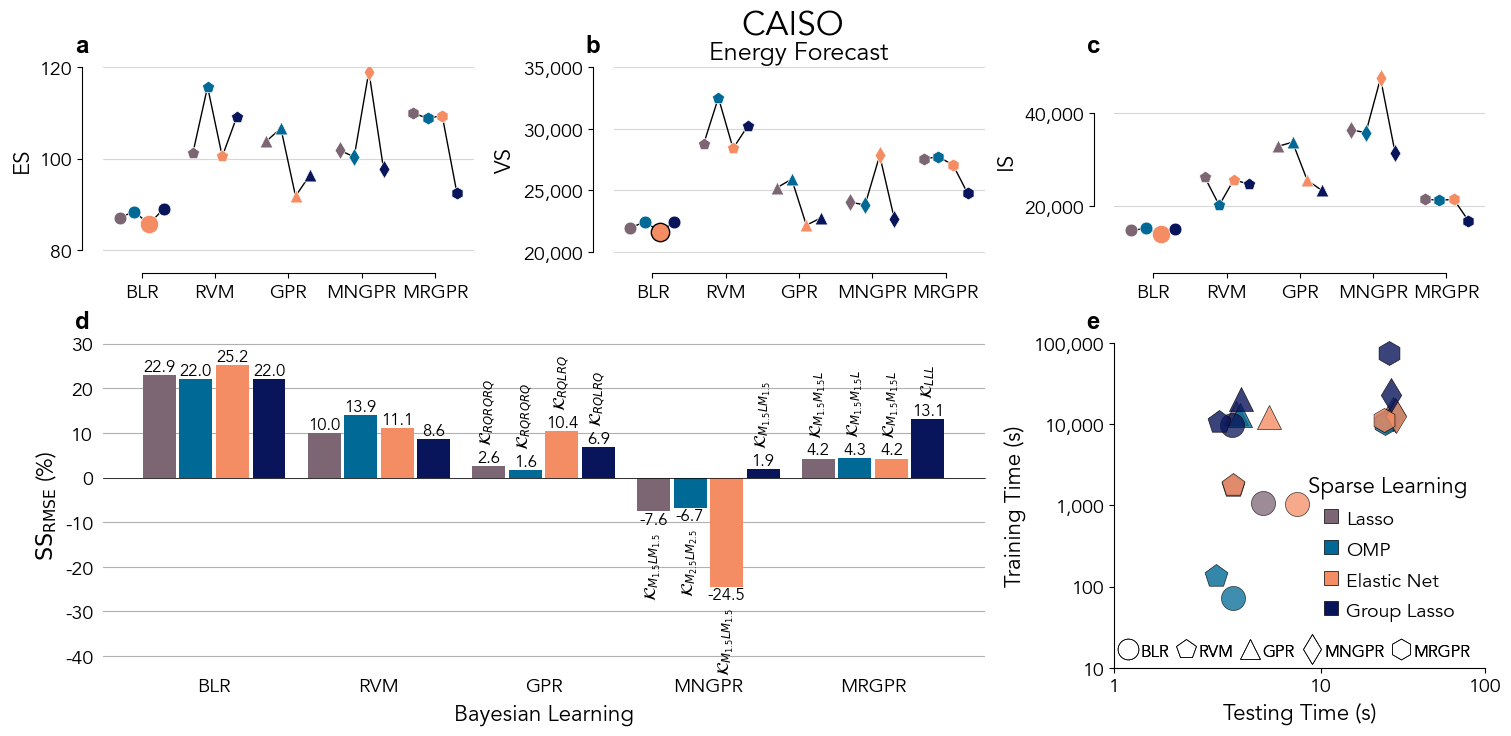

In [28]:
criteria = 'VS'

fig, _ax = plt.subplot_mosaic([['a', 'b', 'c'], ['d', 'd', 'e']], layout  = 'constrained', 
                                                                  figsize = (15, 7),
                             gridspec_kw = {'height_ratios': [1, 1.75]})

for label, ax in _ax.items():
    ax.text(0.0, 1.0, label, transform = (ax.transAxes + ScaledTranslation(-20/72, +7/72, fig.dpi_scale_trans)),
                             fontsize  = 'xx-large', 
                             weight    = "bold",
                             va        = 'bottom', 
                             family    = 'Arial')

_plot_results(_ax['a'], ts_scores_, sl_methods_, dl_methods_, criteria       = criteria,
                                                              score          = 'ES', 
                                                              y_min          = 79.5, 
                                                              y_max          = 120, 
                                                              legend_labels_ = ['Lasso', 'OMP', 'Elastic Net', 'Group Lasso'],
                                                              colors_        = colors_1_,
                                                              legend_title   = 'Sparse Learning', 
                                                              legend         = False, 
                                                              decimals       = False)

_ax['b'].set_title('Energy Forecast', fontsize = 18, y = 1.)

sns.despine(trim   = True, 
            offset = 15, 
            ax     = _ax['a'])

_plot_results(_ax['b'], ts_scores_, sl_methods_, dl_methods_, criteria       = criteria,
                                                              score          = 'VS', 
                                                              y_min          = 19950, 
                                                              y_max          = 35000, 
                                                              legend_labels_ = ['Lasso', 'OMP', 'Elastic Net', 'Group Lasso'],
                                                              colors_        = colors_1_,
                                                              legend_title   = 'Sparse Learning', 
                                                              legend         = False, 
                                                              decimals       = False)

sns.despine(trim   = True, 
            offset = 15, 
            ax     = _ax['b'])

_plot_results(_ax['c'], ts_scores_, sl_methods_, dl_methods_, criteria       = criteria,
                                                              score          = 'IS', 
                                                              y_min          = 9950, 
                                                              y_max          = 50000, 
                                                              legend_labels_ = ['Lasso', 'OMP', 'Elastic Net', 'Group Lasso'],
                                                              colors_        = colors_1_,
                                                              legend_title   = 'Sparse Learning', 
                                                              legend         = False, 
                                                              decimals       = False)

sns.despine(trim   = True, 
            offset = 15, 
            ax     = _ax['c'])

plt.suptitle('        CAISO', fontsize = 24, y = 1.03)


_plot_FS(_ax['d'], ts_scores_, sl_methods_, dl_methods_, zones_, colors_        = colors_1_, 
                                                                 score          = criteria,
                                                                 legend_labels_ = ['Lasso', 'OMP', 'Elastic Net', 'Group Lasso'], 
                                                                 xlabel         = 'Bayesian Learning',
                                                                 ylabel         = r'$\mathrm{SS}_{\mathrm{RMSE}}$ (%)',
                                                                 legend_title   = 'Sparse Learning',
                                                                 legend         = False, 
                                                                 y_min          = -42.6, 
                                                                 y_max          = 30.1)

_plot_time(_ax['e'], ts_scores_, sl_methods_, dl_methods_, score    = criteria, 
                                                           colors_  = colors_1_, 
                                                           legend   = True, 
                                                           x_max    = 100)

plt.savefig(path_to_images + f'caiso_model_selection_{criteria}.pdf', bbox_inches = 'tight',
                                                                                 dpi         = 300)

plt.show()

### Energy Forecast Model Selection - Ignorance Score

ES BLR lasso 86.5116664340785
ES BLR OMP 87.93183170394356
ES BLR elastic_net 84.54623143126842
ES BLR group_lasso 88.76673005819647
ES RVM lasso 176.21599118957252
ES RVM OMP 117.38752184793815
ES RVM elastic_net 120.56161949371074
ES RVM group_lasso 122.63443333938994
ES GPR lasso 87.43339825337179
ES GPR OMP 88.42386648274831
ES GPR elastic_net 86.77406787521173
ES GPR group_lasso 90.1821209841614
ES MNGPR lasso 90.36629668097984
ES MNGPR OMP 86.92614149884938
ES MNGPR elastic_net 89.5723598877877
ES MNGPR group_lasso 94.92196628471726
ES MRGPR lasso 85.92312488906434
ES MRGPR OMP 87.08016779004342
ES MRGPR elastic_net 86.27168497471386
ES MRGPR group_lasso 102.42961942249308
VS BLR lasso 21939.748529214947
VS BLR OMP 22407.356283727633
VS BLR elastic_net 21502.784614543732
VS BLR group_lasso 22293.763588664337
VS RVM lasso 59449.891205553264
VS RVM OMP 31415.349324800063
VS RVM elastic_net 32784.91669307432
VS RVM group_lasso 33046.3760202121
VS GPR lasso 22368.64502438632
VS GPR O

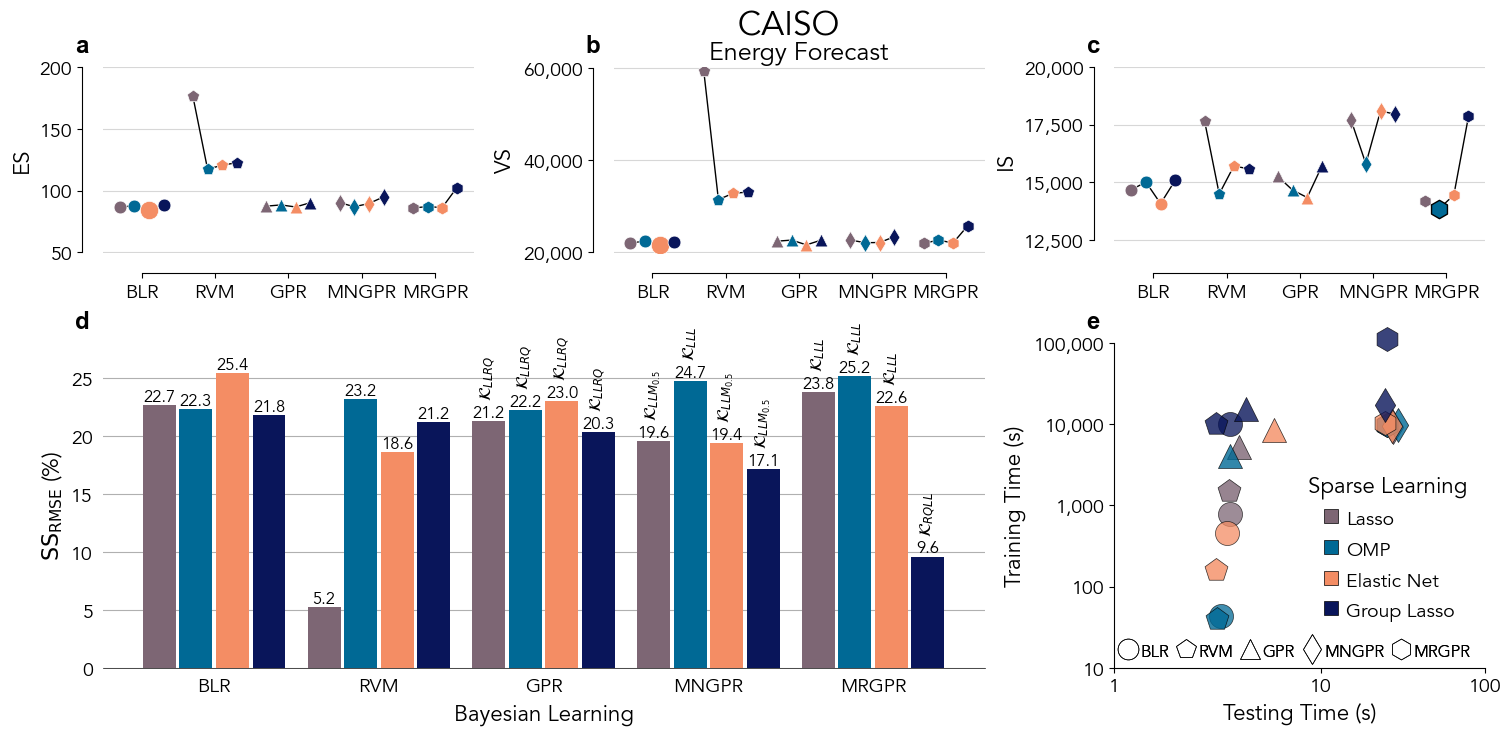

In [29]:
criteria = 'IS'

fig, _ax = plt.subplot_mosaic([['a', 'b', 'c'], 
                               ['d', 'd', 'e']], layout      = 'constrained', 
                                                 figsize     = (15, 7), 
                                                 gridspec_kw = {'height_ratios': [1, 1.75]})

for label, ax in _ax.items():
    ax.text(0.0, 1.0, label, transform = (ax.transAxes + ScaledTranslation(-20/72, +7/72, fig.dpi_scale_trans)),
                             fontsize  = 'xx-large', 
                             weight    = "bold",
                             va        = 'bottom',
                             family    = 'Arial')

_plot_results(_ax['a'], ts_scores_, sl_methods_, dl_methods_, criteria       = criteria,
                                                              score          = 'ES', 
                                                              y_min          = 49.9, 
                                                              y_max          = 200, 
                                                              legend_labels_ = ['Lasso', 'OMP', 'Elastic Net', 'Group Lasso'],
                                                              colors_        = colors_1_,
                                                              legend_title   = 'Sparse Learning', 
                                                              legend         = False, 
                                                              decimals       = False)

_ax['b'].set_title('Energy Forecast', fontsize = 18, y = 1.)

sns.despine(trim   = True, 
            offset = 15, 
            ax     = _ax['a'])

_plot_results(_ax['b'], ts_scores_, sl_methods_, dl_methods_, criteria       = criteria,
                                                              score          = 'VS', 
                                                              y_min          = 19900, 
                                                              y_max          = 60250, 
                                                              legend_labels_ = ['Lasso', 'OMP', 'Elastic Net', 'Group Lasso'],
                                                              colors_        = colors_1_,
                                                              legend_title   = 'Sparse Learning', 
                                                              legend         = False, 
                                                              decimals       = False)

sns.despine(trim   = True, 
            offset = 15, 
            ax     = _ax['b'])

_plot_results(_ax['c'], ts_scores_, sl_methods_, dl_methods_, criteria       = criteria,
                                                              score          = 'IS', 
                                                              y_min          = 11950, 
                                                              y_max          = 20000, 
                                                              legend_labels_ = ['Lasso', 'OMP', 'Elastic Net', 'Group Lasso'],
                                                              colors_        = colors_1_,
                                                              legend_title   = 'Sparse Learning', 
                                                              legend         = False, 
                                                              decimals       = False)

sns.despine(trim   = True, 
            offset = 15, 
            ax     = _ax['c'])

plt.suptitle('       CAISO', fontsize = 24, y = 1.03)


_plot_FS(_ax['d'], ts_scores_, sl_methods_, dl_methods_, zones_, colors_        = colors_1_, 
                                                                 score          = criteria,
                                                                 legend_labels_ = ['Lasso', 'OMP', 'Elastic Net', 'Group Lasso'], 
                                                                 xlabel         = 'Bayesian Learning',
                                                                 ylabel         = r'$\mathrm{SS}_{\mathrm{RMSE}}$ (%)',
                                                                 legend_title   = 'Sparse Learning',
                                                                 legend         = False, 
                                                                 y_min          = 0., 
                                                                 y_max          = 28)

_plot_time(_ax['e'], ts_scores_, sl_methods_, dl_methods_, score    = criteria, 
                                                           colors_  = colors_1_, 
                                                           legend   = True, 
                                                           x_max    = 100)


plt.savefig(path_to_images + f'caiso_model_selection_{criteria}.pdf', bbox_inches = 'tight',
                                                                     dpi         = 300)

plt.show()